# D&D Gameplay Log Analysis Tutorial

This notebook demonstrates how to analyze Dungeons & Dragons gameplay logs

In [1]:
# Import required libraries
import json
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
import numpy as np
from datetime import datetime
from pathlib import Path
import warnings
import os
import sys
import os
import inspect
from pathlib import Path
warnings.filterwarnings('ignore')

import analysis.data_loading as dl
import analysis.basic_metrics as basic
import analysis.creativity_metrics as creativity
import analysis.cohesion_metrics as cohesion

# Set up plotting style
plt.style.use('default')
sns.color_palette("mako")
plt.rcParams['figure.dpi'] = 100

# Create Plots directory
plots_dir = Path('plots')
plots_dir.mkdir(exist_ok=True)
print(f"Created plots directory: {plots_dir}")

# Helper function for saving plots
def save_plot(filename):
    filepath = plots_dir / filename
    plt.savefig(filepath, dpi=300, bbox_inches='tight')
    print(f"Saved: {filepath}")

✅ Anthropic API key loaded
✅ OpenAI API key loaded
✅ Gemini API key loaded
Created plots directory: plots


# Set calculation parameters

In [2]:
#CAMPAIGN_NAME = [
#    '10391-guardians-of-gridori',
#    'llm_campaign_10391-guardians-of-gridori_gemini-1.5-pro_no_players_scratch_20250817_183449',
#    'llm_campaign_10391-guardians-of-gridori_gemini-1.5-pro_players_scratch_20250817_181454',
#    'llm_campaign_10391-guardians-of-gridori_claude-3-7-sonnet-latest_no_players_scratch_20250815_090708',
#    'llm_campaign_10391-guardians-of-gridori_claude-3-7-sonnet-latest_players_scratch_20250814_143138',
#    'llm_campaign_10391-guardians-of-gridori_gpt-4o_no_players_scratch_20250814_131744',
#    'llm_campaign_10391-guardians-of-gridori_gpt-4o_players_scratch_20250814_122435'
#]

#CAMPAIGN_NAME = [
#    '90630-firecat5s-dragon-of-icespire-peak',
#    'llm_campaign_90630-firecat5s-dragon-of-icespire-peak_claude-3-7-sonnet-latest_no_players_scratch_20250815_234149',
#    'llm_campaign_90630-firecat5s-dragon-of-icespire-peak_claude-3-7-sonnet-latest_players_scratch_20250815_204211',
#    'llm_campaign_90630-firecat5s-dragon-of-icespire-peak_gpt-4o_no_players_scratch_20250815_101602',
#    'llm_campaign_90630-firecat5s-dragon-of-icespire-peak_gpt-4o_players_scratch_20250814_153319'
#]


CAMPAIGN_NAME = [
    # HUMAN
    '1262-firedeath-must-die-closed-play-by-post-open-ogg',
    '3135-the-head-of-the-serpent',
    '10391-guardians-of-gridori',
    '20049-age-of-death',
    '89221-banhaven-academy-year-1',
    '90630-firecat5s-dragon-of-icespire-peak',
    '7426-serpent-isle-private-campaign',

    # no players gemini
    'llm_campaign_1262-firedeath-must-die-closed-play-by-post-open-ogg_gemini-1.5-pro_no_players_scratch_20250818_204449',
    'llm_campaign_3135-the-head-of-the-serpent_gemini-1.5-pro_no_players_scratch_20250818_160148',
    'llm_campaign_10391-guardians-of-gridori_gemini-1.5-pro_no_players_scratch_20250817_183449',
    'llm_campaign_20049-age-of-death_gemini-1.5-pro_no_players_scratch_20250818_130018',
    'llm_campaign_89221-banhaven-academy-year-1_gemini-1.5-pro_no_players_scratch_20250818_163025',
    'llm_campaign_90630-firecat5s-dragon-of-icespire-peak_gemini-1.5-pro_no_players_scratch_20250818_095237',
    'llm_campaign_7426-serpent-isle-private-campaign_gemini-1.5-pro_no_players_scratch_20250818_132838',

    # players gemini
    'llm_campaign_1262-firedeath-must-die-closed-play-by-post-open-ogg_gemini-1.5-pro_players_scratch_20250818_145631',
    'llm_campaign_3135-the-head-of-the-serpent_gemini-1.5-pro_players_scratch_20250818_153052',
    'llm_campaign_10391-guardians-of-gridori_gemini-1.5-pro_players_scratch_20250817_181454',
    'llm_campaign_20049-age-of-death_gemini-1.5-pro_players_scratch_20250818_122503',
    'llm_campaign_89221-banhaven-academy-year-1_gemini-1.5-pro_players_scratch_20250818_190918',
    'llm_campaign_90630-firecat5s-dragon-of-icespire-peak_gemini-1.5-pro_players_scratch_20250818_103347',
    'llm_campaign_7426-serpent-isle-private-campaign_gemini-1.5-pro_players_scratch_20250818_133539',

    # no players claude
    'llm_campaign_1262-firedeath-must-die-closed-play-by-post-open-ogg_claude-3-7-sonnet-latest_no_players_scratch_20250819_110000',
    'llm_campaign_3135-the-head-of-the-serpent_claude-3-7-sonnet-latest_no_players_scratch_20250819_153636',
    'llm_campaign_10391-guardians-of-gridori_claude-3-7-sonnet-latest_no_players_scratch_20250815_090708',
    'llm_campaign_89221-banhaven-academy-year-1_claude-3-7-sonnet-latest_no_players_scratch_20250818_192211',
    'llm_campaign_20049-age-of-death_claude-3-7-sonnet-latest_no_players_scratch_20250818_133738',
    'llm_campaign_90630-firecat5s-dragon-of-icespire-peak_claude-3-7-sonnet-latest_no_players_scratch_20250815_234149',
    'llm_campaign_7426-serpent-isle-private-campaign_claude-3-7-sonnet-latest_no_players_scratch_20250818_141059',

    # players claude
    'llm_campaign_1262-firedeath-must-die-closed-play-by-post-open-ogg_claude-3-7-sonnet-latest_players_scratch_20250819_132210',
    'llm_campaign_3135-the-head-of-the-serpent_claude-3-7-sonnet-latest_players_scratch_20250818_154911',
    'llm_campaign_10391-guardians-of-gridori_claude-3-7-sonnet-latest_players_scratch_20250814_143138',
    'llm_campaign_20049-age-of-death_claude-3-7-sonnet-latest_players_scratch_20250818_120952',
    'llm_campaign_89221-banhaven-academy-year-1_claude-3-7-sonnet-latest_players_scratch_20250819_205318',
    'llm_campaign_90630-firecat5s-dragon-of-icespire-peak_claude-3-7-sonnet-latest_players_scratch_20250815_204211',
    'llm_campaign_7426-serpent-isle-private-campaign_claude-3-7-sonnet-latest_players_scratch_20250818_143900',

    # no players chatgpt
    'llm_campaign_1262-firedeath-must-die-closed-play-by-post-open-ogg_gpt-4o_no_players_scratch_20250816_110159',
    'llm_campaign_3135-the-head-of-the-serpent_gpt-4o_no_players_scratch_20250816_190300',
    'llm_campaign_10391-guardians-of-gridori_gpt-4o_no_players_scratch_20250814_131744',
    'llm_campaign_89221-banhaven-academy-year-1_gpt-4o_no_players_scratch_20250816_183355',
    'llm_campaign_20049-age-of-death_gpt-4o_no_players_scratch_20250816_213933',
    'llm_campaign_90630-firecat5s-dragon-of-icespire-peak_gpt-4o_no_players_scratch_20250815_101602',
    'llm_campaign_7426-serpent-isle-private-campaign_gpt-4o_no_players_scratch_20250817_100448',

    # players chatgpt
    'llm_campaign_1262-firedeath-must-die-closed-play-by-post-open-ogg_gpt-4o_players_scratch_20250816_125646',
    'llm_campaign_3135-the-head-of-the-serpent_gpt-4o_players_scratch_20250816_194054',
    'llm_campaign_10391-guardians-of-gridori_gpt-4o_players_scratch_20250814_122435',
    'llm_campaign_20049-age-of-death_gpt-4o_players_scratch_20250816_212424',
    'llm_campaign_89221-banhaven-academy-year-1_gpt-4o_players_scratch_20250816_140525',
    'llm_campaign_90630-firecat5s-dragon-of-icespire-peak_gpt-4o_players_scratch_20250814_153319',
    'llm_campaign_7426-serpent-isle-private-campaign_gpt-4o_players_scratch_20250817_101144'
]


source = CAMPAIGN_NAME
source = 'human'
max_campaigns = 985#969
messages_per_session = 5
force_refresh = False
scene_length = 175

# Calculate game log analyses

In [ ]:
dfs = dl.load_campaigns(source=source, max_campaigns = max_campaigns, messages_per_session=messages_per_session, apply_corrections=False)

basic_metrics = basic.analyze_basic_metrics(dfs, force_refresh=force_refresh)

creativity_metrics = creativity.analyze_creativity(dfs,
                                                   force_refresh=False)

#dsi_metrics = creativity.analyze_dsi(dfs,
#                                     force_refresh=True,
#                                     target_words=scene_length)

cohesion_metrics = cohesion.analyze_cohesion(dfs,
                                             messages_per_session=5,
                                             force_refresh=False)

print(len(CAMPAIGN_NAME))

📂 Loading campaigns from individual files in /Users/annie/Code/Repositories/dnd-dynamics/data/raw-human-games/individual_campaigns
📊 Found 985 campaign files
🎯 Loading first 985 campaigns (max_campaigns=985)


Loading campaigns:   0%|          | 0/985 [00:00<?, ?it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 10391-guardians-of-gridori
✅ Corrections completed for campaign: 10391-guardians-of-gridori
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 10625-wrath-of-ashardalon
⚠️ Character name conflict: 'Dhel' used by players ['LightSpeed', 'dryadgrl13']
🔄 Player LightSpeed: 'Dhel' → 'Menus'


Loading campaigns:   0%|          | 2/985 [00:01<12:10,  1.35it/s]

✅ Player dryadgrl13: 'Dhel' (confirmed correct)
✅ Corrections completed for campaign: 10625-wrath-of-ashardalon
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 10639-the-crypt-of-the-dreaming-dead
✅ Corrections completed for campaign: 10639-the-crypt-of-the-dreaming-dead


Loading campaigns:   0%|          | 3/985 [00:01<09:39,  1.69it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 10672-whispers-of-dissent
⚠️ Character name conflict: 'Lera' used by players ['DungeonMaya', 'DungeonDad']
✅ Player DungeonMaya: 'Lera' (confirmed correct)
🔄 Player DungeonDad: 'Lera' → 'Zamar'
✅ Corrections completed for campaign: 10672-whispers-of-dissent


Loading campaigns:   0%|          | 4/985 [00:03<16:06,  1.02it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 10826-ye-ol-yarn-spun-legend
⚠️ Character name conflict: 'Hjol' used by players ['TheGmoat', 'ArgentTheWise']
🔄 Player TheGmoat: 'Hjol' → 'Hjolmond'


Loading campaigns:   1%|          | 5/985 [00:04<17:57,  1.10s/it]

🔄 Player ArgentTheWise: 'Hjol' → 'Mythanthar Falynn'
✅ Corrections completed for campaign: 10826-ye-ol-yarn-spun-legend
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 11146-tomb-of-annihilation-4pbp
✅ Corrections completed for campaign: 11146-tomb-of-annihilation-4pbp


Loading campaigns:   1%|          | 7/985 [00:05<10:53,  1.50it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 11153-in-the-shadows-of-a-stone-titan
✅ Corrections completed for campaign: 11153-in-the-shadows-of-a-stone-titan
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 11414-classic-crawl-the-lost-city
✅ Corrections completed for campaign: 11414-classic-crawl-the-lost-city


Loading campaigns:   1%|          | 9/985 [00:05<06:27,  2.52it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 11531-legacy-of-the-ascended-ic-thread
✅ Corrections completed for campaign: 11531-legacy-of-the-ascended-ic-thread
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 11642-cellar-of-death-group-already-full
⚠️ Character name conflict: 'Helga' used by players ['TinForged', 'SentientSpellbook']
🔄 Player TinForged: 'Helga' → 'Malamus'


Loading campaigns:   1%|▏         | 13/985 [00:07<05:19,  3.04it/s]

🔄 Player SentientSpellbook: 'Helga' → 'Yllcerys'
✅ Corrections completed for campaign: 11642-cellar-of-death-group-already-full
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 11752-prison-break
✅ Corrections completed for campaign: 11752-prison-break
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 11767-goblins-the-nightrot-clan-ballad
✅ Corrections completed for campaign: 11767-goblins-the-nightrot-clan-ballad
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 11871-the-land-of-enlightenment-1-0-homebrew
✅ Corrections completed for campaign: 11871-the-land-of-enlightenment-1-0-homebrew
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 11878-the-wildlands-of-etheryl
✅ Corrections completed for campaign: 11878-the-wildlands-of-etheryl
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 11910-pillagers-of-ixalan-ic
⚠️ Character name confl

Loading campaigns:   2%|▏         | 15/985 [00:08<07:36,  2.13it/s]

✅ Player JcAndD: 'Polly' (confirmed correct)
✅ Corrections completed for campaign: 11910-pillagers-of-ixalan-ic
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 11940-legerdemain-a-little-hocus-pocus
✅ Corrections completed for campaign: 11940-legerdemain-a-little-hocus-pocus
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 11998-5e-rise-of-the-runelords-ic-spanish
✅ Corrections completed for campaign: 11998-5e-rise-of-the-runelords-ic-spanish


Loading campaigns:   2%|▏         | 17/985 [00:09<06:09,  2.62it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 12007-the-glory-of-the-coliseum-always-recruiting
🗑️ Removing single-post characters: ['Talmich', 'Kogu', '’ve', 'Vagabon', "Sel'eman", 'Kulum', 'Glacia', 'Zeekrik']
⚠️ Character name conflict: 'Shmitty' used by players ['Lawdawg', 'Keneux']
⚠️ Character name conflict: 'Rothander' used by players ['Desmond_II', 'Hillbilly79']
⚠️ Character name conflict: 'Morthos' used by players ['FrenchyTheDM', 'DarkBlood87']
⚠️ Character name conflict: 'Orileo' used by players ['TheAnvil', 'ThalaiDawncaller']
✅ Player Lawdawg: 'Shmitty' (confirmed correct)
🔄 Player Keneux: 'Shmitty' → 'Swigg'
✅ Player Desmond_II: 'Rothander' (confirmed correct)
🔄 Player Hillbilly79: 'Rothander' → 'Paren'
✅ Player FrenchyTheDM: 'Morthos' (confirmed correct)
🔄 Player DarkBlood87: 'Morthos' → 'Talmich'
🔄 Player TheAnvil: 'Orileo' → 'J-94'
🔄 Player ThalaiDawncaller: 'Orileo' → 'Apium Graveolens'
✅ Corrections completed for campaign: 12007-the

Loading campaigns:   2%|▏         | 18/985 [00:16<26:26,  1.64s/it]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 12013-tarvyns-world-of-magnificent-wonders-and-oddities
✅ Corrections completed for campaign: 12013-tarvyns-world-of-magnificent-wonders-and-oddities
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 12089-the-tavern-casual-rp-socializing
⚠️ Character name conflict: 'Og' used by players ['featherhalf', 'Necmo']
⚠️ Character name conflict: 'Morgan' used by players ['Bandersnatch22', 'NeoMagus']
🔄 Player featherhalf: 'Og' → 'Gyro'
🔄 Player Necmo: 'Og' → 'Ogoth Kinshield'
🔄 Player Bandersnatch22: 'Morgan' → 'Sorrow’s Clutch'


Loading campaigns:   2%|▏         | 20/985 [00:19<26:57,  1.68s/it]

✅ Player NeoMagus: 'Morgan' (confirmed correct)
✅ Corrections completed for campaign: 12089-the-tavern-casual-rp-socializing
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 12120-a-rough-night
✅ Corrections completed for campaign: 12120-a-rough-night


Loading campaigns:   2%|▏         | 22/985 [00:19<17:28,  1.09s/it]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 12136-plunge-into-the-underdark
✅ Corrections completed for campaign: 12136-plunge-into-the-underdark
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 12251-rogue-monsters-in-game-thread
✅ Corrections completed for campaign: 12251-rogue-monsters-in-game-thread
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 12296-atriaxs-return
✅ Corrections completed for campaign: 12296-atriaxs-return


Loading campaigns:   3%|▎         | 25/985 [00:20<09:26,  1.70it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 12394-monster-hunters
✅ Corrections completed for campaign: 12394-monster-hunters
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 12511-critical-role-demons-and-derolos
⚠️ Character name conflict: 'Calder' used by players ['Saute_Monkey', 'terasques']
✅ Player Saute_Monkey: 'Calder' (confirmed correct)


Loading campaigns:   3%|▎         | 26/985 [00:21<12:45,  1.25it/s]

✅ Player terasques: 'Calder' (confirmed correct)
✅ Corrections completed for campaign: 12511-critical-role-demons-and-derolos
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 12528-tieflings-of-annihilation
✅ Corrections completed for campaign: 12528-tieflings-of-annihilation


Loading campaigns:   3%|▎         | 27/985 [00:22<11:19,  1.41it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 12554-dungeons-and-jumaji
✅ Corrections completed for campaign: 12554-dungeons-and-jumaji
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 1262-firedeath-must-die-closed-play-by-post-open-ogg
📝 Applying manual character corrections: {'FaeDra': 'Rylei Dreemurr'}
🗑️ Removing single-post characters: ['Sry']
⚠️ Character name conflict: 'Argo' used by players ['Mutant_vapes27', 'Stubbazubba']
🔄 Player Mutant_vapes27: 'Argo' → 'Dro Coborel'


Loading campaigns:   3%|▎         | 30/985 [00:23<09:29,  1.68it/s]

✅ Player Stubbazubba: 'Argo' (confirmed correct)
✅ Corrections completed for campaign: 1262-firedeath-must-die-closed-play-by-post-open-ogg
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 12783-chosen-homebrew-monster-hunters
✅ Corrections completed for campaign: 12783-chosen-homebrew-monster-hunters
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 12878-eon-survival-at-sea
✅ Corrections completed for campaign: 12878-eon-survival-at-sea


Loading campaigns:   3%|▎         | 33/985 [00:24<06:07,  2.59it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 13123-the-land-of-woes
✅ Corrections completed for campaign: 13123-the-land-of-woes
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 13138-dreams-of-dagon-in-game-play
✅ Corrections completed for campaign: 13138-dreams-of-dagon-in-game-play
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 13139-dreams-of-dagon-game-discussion
⚠️ Character name conflict: 'Adoy' used by players ['Kolbitr', 'Synthil']
✅ Player Kolbitr: 'Adoy' (confirmed correct)


Loading campaigns:   3%|▎         | 34/985 [00:26<10:03,  1.58it/s]

🔄 Player Synthil: 'Adoy' → 'Ayoola'
✅ Corrections completed for campaign: 13139-dreams-of-dagon-game-discussion
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 13174-dragon-of-autumn-icc
⚠️ Character name conflict: 'Geoff' used by players ['NerdOrNot', 'Necmo']
🔄 Player NerdOrNot: 'Geoff' → 'Tyrros'


Loading campaigns:   4%|▎         | 35/985 [00:27<13:44,  1.15it/s]

🔄 Player Necmo: 'Geoff' → 'Xorn'
✅ Corrections completed for campaign: 13174-dragon-of-autumn-icc
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 13325-lost-magics-epic-of-pre-made-proportions
⚠️ Character name conflict: 'Morgan' used by players ['NeoMagus', 'FrandalSilvereyes']
✅ Player NeoMagus: 'Morgan' (confirmed correct)
🔄 Player FrandalSilvereyes: 'Morgan' → 'Cyrnair Thonrar'
✅ Corrections completed for campaign: 13325-lost-magics-epic-of-pre-made-proportions


Loading campaigns:   4%|▎         | 36/985 [00:29<18:02,  1.14s/it]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 13340-temple-of-ishassara
✅ Corrections completed for campaign: 13340-temple-of-ishassara


Loading campaigns:   4%|▍         | 37/985 [00:30<15:51,  1.00s/it]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 13431-the-fake-one
⚠️ Character name conflict: 'Gar' used by players ['DirtyDogP', 'Spiritgoyle']
🔄 Player DirtyDogP: 'Gar' → 'Hob'


Loading campaigns:   4%|▍         | 38/985 [00:31<17:16,  1.10s/it]

✅ Player Spiritgoyle: 'Gar' (confirmed correct)
✅ Corrections completed for campaign: 13431-the-fake-one
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 13445-lost-mine-of-phandelver-revised
🗑️ Removing single-post characters: ['Ivellios Tallwood']
✅ Corrections completed for campaign: 13445-lost-mine-of-phandelver-revised


Loading campaigns:   4%|▍         | 39/985 [00:31<13:46,  1.14it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 13483-princes-of-the-apocalypse
✅ Corrections completed for campaign: 13483-princes-of-the-apocalypse


Loading campaigns:   4%|▍         | 40/985 [00:32<10:54,  1.44it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 13503-glory-or-revenge
✅ Corrections completed for campaign: 13503-glory-or-revenge
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 13513-storm-kings-thunder
✅ Corrections completed for campaign: 13513-storm-kings-thunder


Loading campaigns:   4%|▍         | 42/985 [00:32<06:51,  2.29it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 13626-the-dragon-prince
✅ Corrections completed for campaign: 13626-the-dragon-prince
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 13844-lost-mine-of-phandelver-kolbitr-dm
✅ Corrections completed for campaign: 13844-lost-mine-of-phandelver-kolbitr-dm


Loading campaigns:   5%|▍         | 46/985 [00:33<04:02,  3.88it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 13875-sorte-nebbiosa-cuori-assenti-ita
✅ Corrections completed for campaign: 13875-sorte-nebbiosa-cuori-assenti-ita
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 13920-princes-of-the-apocalypse
🗑️ Removing single-post characters: ['n’t']
✅ Corrections completed for campaign: 13920-princes-of-the-apocalypse
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 14005-ale-or-nothing-campaign-ended
✅ Corrections completed for campaign: 14005-ale-or-nothing-campaign-ended


Loading campaigns:   5%|▍         | 48/985 [00:33<03:09,  4.93it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 14103-trouble-in-delving
✅ Corrections completed for campaign: 14103-trouble-in-delving
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 14168-out-of-the-abyss
✅ Corrections completed for campaign: 14168-out-of-the-abyss
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 14191-high-times-at-low-tides
✅ Corrections completed for campaign: 14191-high-times-at-low-tides


Loading campaigns:   5%|▌         | 52/985 [00:33<02:13,  7.01it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 14243-dead-god-excavation-5pbp
✅ Corrections completed for campaign: 14243-dead-god-excavation-5pbp
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 14349-not-another-lost-mine-of-phandelver-campaign
✅ Corrections completed for campaign: 14349-not-another-lost-mine-of-phandelver-campaign
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 14352-al-legal-lmop-ic
✅ Corrections completed for campaign: 14352-al-legal-lmop-ic


Loading campaigns:   5%|▌         | 54/985 [00:34<02:20,  6.62it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 14377-labyrinth-of-the-goblin-king
🗑️ Removing single-post characters: ['Tyrv']
✅ Corrections completed for campaign: 14377-labyrinth-of-the-goblin-king
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 14630-order-of-medusa-homebrew-campaign
✅ Corrections completed for campaign: 14630-order-of-medusa-homebrew-campaign


Loading campaigns:   6%|▌         | 56/985 [00:34<01:48,  8.54it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 14633-dungeon-divers-unlimited
✅ Corrections completed for campaign: 14633-dungeon-divers-unlimited
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 14753-hoard-of-the-dragon-queen
✅ Corrections completed for campaign: 14753-hoard-of-the-dragon-queen


Loading campaigns:   6%|▌         | 58/985 [00:34<02:11,  7.03it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 14763-the-sunless-citadel-6pbp
✅ Corrections completed for campaign: 14763-the-sunless-citadel-6pbp
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 14765-khazad-dooom-productions-ic
✅ Corrections completed for campaign: 14765-khazad-dooom-productions-ic
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 14790-league-of-justice
🗑️ Removing single-post characters: ['’ll']
✅ Corrections completed for campaign: 14790-league-of-justice


Loading campaigns:   6%|▌         | 60/985 [00:34<01:44,  8.84it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 14842-legacy-of-the-ascended-2nd-iteration
✅ Corrections completed for campaign: 14842-legacy-of-the-ascended-2nd-iteration
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 14881-tomb-of-annihilation
✅ Corrections completed for campaign: 14881-tomb-of-annihilation


Loading campaigns:   6%|▋         | 62/985 [00:35<02:53,  5.33it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 15093-curse-of-strahd
🗑️ Removing single-post characters: ['Ariris Dragonsbane']
⚠️ Character name conflict: 'Patch' used by players ['Tyrannosary', 'jimmop']
✅ Player Tyrannosary: 'Patch' (confirmed correct)
✅ Player jimmop: 'Patch' (confirmed correct)
✅ Corrections completed for campaign: 15093-curse-of-strahd


Loading campaigns:   6%|▋         | 63/985 [00:36<07:20,  2.10it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 15154-new-adventure
✅ Corrections completed for campaign: 15154-new-adventure


Loading campaigns:   6%|▋         | 64/985 [00:37<07:07,  2.15it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 15169-the-windhovers-call
✅ Corrections completed for campaign: 15169-the-windhovers-call


Loading campaigns:   7%|▋         | 67/985 [00:37<04:10,  3.67it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 1522-kobold-fight-club-full-currently
✅ Corrections completed for campaign: 1522-kobold-fight-club-full-currently
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 15279-behind-enemy-lines
✅ Corrections completed for campaign: 15279-behind-enemy-lines
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 15310-bartys-lost-mine-of-phandelver
✅ Corrections completed for campaign: 15310-bartys-lost-mine-of-phandelver


Loading campaigns:   7%|▋         | 68/985 [00:38<05:09,  2.96it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 15370-lmop-in-game-play
⚠️ Character name conflict: 'Ragna' used by players ['TheSunsFirstborn', 'Widowleaf']
✅ Player TheSunsFirstborn: 'Ragna' (confirmed correct)


Loading campaigns:   7%|▋         | 69/985 [00:39<08:42,  1.75it/s]

🔄 Player Widowleaf: 'Ragna' → 'Ragana Thunderspike'
✅ Corrections completed for campaign: 15370-lmop-in-game-play
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 15462-wibwubs-campaign-storm-kings-thunder
✅ Corrections completed for campaign: 15462-wibwubs-campaign-storm-kings-thunder
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 15526-stellarium-of-the-vinteralf
✅ Corrections completed for campaign: 15526-stellarium-of-the-vinteralf


Loading campaigns:   7%|▋         | 71/985 [00:39<05:58,  2.55it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 15563-dragons-of-despair-dragon-lance
✅ Corrections completed for campaign: 15563-dragons-of-despair-dragon-lance
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 15568-fiefdoms-in-a-broken-land
🗑️ Removing single-post characters: ['Aery Ulembe', 'Thokk', '-Kane Redwall-', 'Jeff']
✅ Corrections completed for campaign: 15568-fiefdoms-in-a-broken-land


Loading campaigns:   8%|▊         | 74/985 [00:40<04:01,  3.77it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 15583-ive-fallen-down-and-i-cant-get-back-up
✅ Corrections completed for campaign: 15583-ive-fallen-down-and-i-cant-get-back-up
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 15627-pbp-after-apocalypse
✅ Corrections completed for campaign: 15627-pbp-after-apocalypse


Loading campaigns:   8%|▊         | 75/985 [00:40<03:51,  3.93it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 15663-adventurers-never-rests
✅ Corrections completed for campaign: 15663-adventurers-never-rests


Loading campaigns:   8%|▊         | 76/985 [00:40<03:51,  3.93it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 15917-pit-of-vipers-chapter-one
⚠️ Character name conflict: 'Watl' used by players ['Simmon', 'Steedling']
🔄 Player Simmon: 'Watl' → 'Watl Wiggins'
🔄 Player Steedling: 'Watl' → 'Trust'
✅ Corrections completed for campaign: 15917-pit-of-vipers-chapter-one


Loading campaigns:   8%|▊         | 77/985 [00:42<08:30,  1.78it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 15935-sail-on-sailor
⚠️ Character name conflict: 'Rook' used by players ['Necmo', 'Hexblade37']
🔄 Player Necmo: 'Rook' → 'Carolinas'


Loading campaigns:   8%|▊         | 78/985 [00:43<11:49,  1.28it/s]

🔄 Player Hexblade37: 'Rook' → 'Gerruk Smith'
✅ Corrections completed for campaign: 15935-sail-on-sailor
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 16126-otora-out-of-character-discussion
⚠️ Character name conflict: 'Carmen' used by players ['Conlaed', 'WhitsEnd']
✅ Player Conlaed: 'Carmen' (confirmed correct)


Loading campaigns:   8%|▊         | 79/985 [00:45<15:38,  1.04s/it]

✅ Player WhitsEnd: 'Carmen' (confirmed correct)
✅ Corrections completed for campaign: 16126-otora-out-of-character-discussion
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 16137-the-call-of-lon-dia
✅ Corrections completed for campaign: 16137-the-call-of-lon-dia


Loading campaigns:   8%|▊         | 82/985 [00:45<07:48,  1.93it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 16289-spanish-adventures-in-taldorei
✅ Corrections completed for campaign: 16289-spanish-adventures-in-taldorei
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 16421-otora-story-thread
✅ Corrections completed for campaign: 16421-otora-story-thread
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 16427-clerical-heirs-a-divine-mystery
🗑️ Removing single-post characters: ['Aasimar', 'Arthur']
⚠️ Character name conflict: 'Demoiselle' used by players ['Jack_Joke', 'Rivina']
🔄 Player Jack_Joke: 'Demoiselle' → 'Simeon Grey'


Loading campaigns:   8%|▊         | 83/985 [00:47<10:49,  1.39it/s]

🔄 Player Rivina: 'Demoiselle' → 'Dawnlord Wintermoon'
✅ Corrections completed for campaign: 16427-clerical-heirs-a-divine-mystery
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 16526-league-of-improbable-adventurers-chapter-1-of
🗑️ Removing single-post characters: ['Elven Sorcerer']
✅ Corrections completed for campaign: 16526-league-of-improbable-adventurers-chapter-1-of


Loading campaigns:   9%|▊         | 84/985 [00:47<09:09,  1.64it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 16560-lost-in-the-endless-tower-by-pokepaladdy
⚠️ Character name conflict: 'Killian' used by players ['YoFizz', 'TonyBuckets']
🔄 Player YoFizz: 'Killian' → 'Thursday'
✅ Player TonyBuckets: 'Killian' (confirmed correct)
✅ Corrections completed for campaign: 16560-lost-in-the-endless-tower-by-pokepaladdy


Loading campaigns:   9%|▉         | 87/985 [00:49<07:41,  1.95it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 1657-trouble-in-timberbottom
✅ Corrections completed for campaign: 1657-trouble-in-timberbottom
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 16614-mightyowls-taldorei-campaign-group-2
✅ Corrections completed for campaign: 16614-mightyowls-taldorei-campaign-group-2
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 16629-lost-mine-of-phandelver-by-pokepaladdy
✅ Corrections completed for campaign: 16629-lost-mine-of-phandelver-by-pokepaladdy


Loading campaigns:   9%|▉         | 88/985 [00:49<06:36,  2.26it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 16683-mightyowls-taldorei-campaign-group-1
🗑️ Removing single-post characters: ['Wittrun']
✅ Corrections completed for campaign: 16683-mightyowls-taldorei-campaign-group-1
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 16687-the-shackled-city
✅ Corrections completed for campaign: 16687-the-shackled-city


Loading campaigns:   9%|▉         | 90/985 [00:50<05:43,  2.61it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 16741-the-shade-over-runewarren
✅ Corrections completed for campaign: 16741-the-shade-over-runewarren
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 16830-knights-of-the-day-lost-mine-of-phandelver
✅ Corrections completed for campaign: 16830-knights-of-the-day-lost-mine-of-phandelver


Loading campaigns:  10%|▉         | 94/985 [00:50<03:30,  4.23it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 16964-one-shot-meeting-in-deepnight-ft-greyhawk
✅ Corrections completed for campaign: 16964-one-shot-meeting-in-deepnight-ft-greyhawk
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 16990-dunes-and-dragons-an-egyptian-themed-adventure
✅ Corrections completed for campaign: 16990-dunes-and-dragons-an-egyptian-themed-adventure
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 17072-an-adventure-of-amazing-proportions-and-mixed
🗑️ Removing single-post characters: ['Vyncent']
✅ Corrections completed for campaign: 17072-an-adventure-of-amazing-proportions-and-mixed


Loading campaigns:  10%|▉         | 96/985 [00:50<02:50,  5.22it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 17175-the-guild-discussion
🗑️ Removing single-post characters: ['Howdy']
✅ Corrections completed for campaign: 17175-the-guild-discussion
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 17247-spanish-dark-eras-in-eliorien
⚠️ Character name conflict: 'Zan' used by players ['Theagan', 'IscalF']
🔄 Player Theagan: 'Zan' → 'Galeath'


Loading campaigns:  10%|▉         | 97/985 [00:52<06:30,  2.27it/s]

🔄 Player IscalF: 'Zan' → 'Zanarcot'
✅ Corrections completed for campaign: 17247-spanish-dark-eras-in-eliorien
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 17274-the-guild-game-thread
✅ Corrections completed for campaign: 17274-the-guild-game-thread


Loading campaigns:  10%|▉         | 98/985 [00:53<10:43,  1.38it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 17356-tomb-of-annihilation-boat-party-edition
⚠️ Character name conflict: 'Fenrir' used by players ['Lumas_Ala', 'Nova_Belle']
✅ Player Lumas_Ala: 'Fenrir' (confirmed correct)


Loading campaigns:  10%|█         | 99/985 [00:55<15:21,  1.04s/it]

✅ Player Nova_Belle: 'Fenrir' (confirmed correct)
✅ Corrections completed for campaign: 17356-tomb-of-annihilation-boat-party-edition
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 17496-eon-scorched-skies
⚠️ Character name conflict: 'Reigntail' used by players ['BKHusker', 'NeoMagus']
✅ Player BKHusker: 'Reigntail' (confirmed correct)


Loading campaigns:  10%|█         | 100/985 [00:56<16:52,  1.14s/it]

✅ Player NeoMagus: 'Reigntail' (confirmed correct)
✅ Corrections completed for campaign: 17496-eon-scorched-skies
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 17613-the-full-dark-stone
✅ Corrections completed for campaign: 17613-the-full-dark-stone


Loading campaigns:  10%|█         | 101/985 [00:57<12:52,  1.14it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 17623-a-journey-across-the-planes
⚠️ Character name conflict: 'Zotar' used by players ['Madclergy', 'Kyleh2486']
✅ Player Madclergy: 'Zotar' (confirmed correct)


Loading campaigns:  10%|█         | 102/985 [00:58<16:05,  1.09s/it]

🔄 Player Kyleh2486: 'Zotar' → 'Ammom'
✅ Corrections completed for campaign: 17623-a-journey-across-the-planes
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 17747-the-forge-of-fury-7pbp
⚠️ Character name conflict: 'Luthien' used by players ['Slytuna', 'o_Merlin_o']
🔄 Player Slytuna: 'Luthien' → 'Thoben Battlebeard'


Loading campaigns:  10%|█         | 103/985 [01:00<18:08,  1.23s/it]

🔄 Player o_Merlin_o: 'Luthien' → 'Lúthien Adril'
✅ Corrections completed for campaign: 17747-the-forge-of-fury-7pbp
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 17857-lost-mines-of-phandelver-amazing-edition
✅ Corrections completed for campaign: 17857-lost-mines-of-phandelver-amazing-edition
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 17970-shepherds-crossing
✅ Corrections completed for campaign: 17970-shepherds-crossing


Loading campaigns:  11%|█         | 106/985 [01:00<08:53,  1.65it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 17972-curse-of-strahd-first-group
✅ Corrections completed for campaign: 17972-curse-of-strahd-first-group
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 17982-lost-mine-of-phandelver
⚠️ Character name conflict: 'Leek' used by players ['Wolvesgar', 'mpeloquin']
⚠️ Character name conflict: 'Katerielle' used by players ['Katerielle', 'Giasrhen']
⚠️ Character name conflict: 'Elila' used by players ['FleurangeParent', 'Wysperra']
🔄 Player Wolvesgar: 'Leek' → 'Kitryn'
✅ Player mpeloquin: 'Leek' (confirmed correct)
✅ Player Katerielle: 'Katerielle' (confirmed correct)
✅ Player Giasrhen: 'Katerielle' (confirmed correct)
✅ Player FleurangeParent: 'Elila' (confirmed correct)
✅ Player Wysperra: 'Elila' (confirmed correct)
✅ Corrections completed for campaign: 17982-lost-mine-of-phandelver


Loading campaigns:  11%|█         | 109/985 [01:05<14:29,  1.01it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 18129-from-dusk-till-dawn-modified-sunless-citadel
🗑️ Removing single-post characters: ['Thomas']
✅ Corrections completed for campaign: 18129-from-dusk-till-dawn-modified-sunless-citadel
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 18286-city-of-the-spider-queen-icc
✅ Corrections completed for campaign: 18286-city-of-the-spider-queen-icc
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 18301-price-of-misfortune-ended
⚠️ Character name conflict: 'Crassus' used by players ['Kyleh2486', 'Sarcasticfury']
🔄 Player Kyleh2486: 'Crassus' → 'Erlan'


Loading campaigns:  11%|█         | 110/985 [01:06<15:04,  1.03s/it]

✅ Player Sarcasticfury: 'Crassus' (confirmed correct)
✅ Corrections completed for campaign: 18301-price-of-misfortune-ended
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 18442-the-bounders-ooc
✅ Corrections completed for campaign: 18442-the-bounders-ooc
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 18511-platinum-plated-keys
✅ Corrections completed for campaign: 18511-platinum-plated-keys


Loading campaigns:  11%|█▏        | 112/985 [01:07<09:35,  1.52it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 18546-reign-of-villains-game-thread
✅ Corrections completed for campaign: 18546-reign-of-villains-game-thread
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 18613-the-bounders-story
✅ Corrections completed for campaign: 18613-the-bounders-story


Loading campaigns:  12%|█▏        | 114/985 [01:07<07:11,  2.02it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 18713-delian-tomb-iv
⚠️ Character name conflict: 'Vokrul' used by players ['Sturm55', 'Nattieoak']
🔄 Player Sturm55: 'Vokrul' → 'Sturm'


Loading campaigns:  12%|█▏        | 116/985 [01:09<08:16,  1.75it/s]

✅ Player Nattieoak: 'Vokrul' (confirmed correct)
✅ Corrections completed for campaign: 18713-delian-tomb-iv
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 18746-journey-unto-chaos
✅ Corrections completed for campaign: 18746-journey-unto-chaos
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 18865-arsenal-of-the-orc-lord
✅ Corrections completed for campaign: 18865-arsenal-of-the-orc-lord


Loading campaigns:  12%|█▏        | 117/985 [01:09<07:00,  2.06it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 18881-city-of-cresthall
✅ Corrections completed for campaign: 18881-city-of-cresthall


Loading campaigns:  12%|█▏        | 118/985 [01:09<07:30,  1.93it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 18919-dark-dealings-city-of-cresthall
✅ Corrections completed for campaign: 18919-dark-dealings-city-of-cresthall
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 19115-the-seven-saints-adventuring-company-group-thread
⚠️ Character name conflict: 'Crispy' used by players ['CrispyDM', 'FrandalSilvereyes']
✅ Player CrispyDM: 'Crispy' (confirmed correct)


Loading campaigns:  12%|█▏        | 122/985 [01:11<06:13,  2.31it/s]

🔄 Player FrandalSilvereyes: 'Crispy' → 'Dar'quilyn Redn'Avir'
✅ Corrections completed for campaign: 19115-the-seven-saints-adventuring-company-group-thread
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 19154-a-candle-in-the-dark-in-game-play
✅ Corrections completed for campaign: 19154-a-candle-in-the-dark-in-game-play
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 19348-hoard-of-the-dragon-queen
✅ Corrections completed for campaign: 19348-hoard-of-the-dragon-queen
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 19362-seven-saints-crimson-fang
✅ Corrections completed for campaign: 19362-seven-saints-crimson-fang


Loading campaigns:  13%|█▎        | 124/985 [01:12<05:27,  2.63it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 19364-seven-saints-azure-claw
✅ Corrections completed for campaign: 19364-seven-saints-azure-claw
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 19381-of-gunsmoke-and-giants-game-thread
✅ Corrections completed for campaign: 19381-of-gunsmoke-and-giants-game-thread


Loading campaigns:  13%|█▎        | 127/985 [01:12<03:15,  4.38it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 19709-bartys-blood-kin-doom-portals-part-0
✅ Corrections completed for campaign: 19709-bartys-blood-kin-doom-portals-part-0
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 19796-long-term-toa
🗑️ Removing single-post characters: ['Devlin']
✅ Corrections completed for campaign: 19796-long-term-toa
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 19822-maze-of-the-blue-medusa-9-pbp
✅ Corrections completed for campaign: 19822-maze-of-the-blue-medusa-9-pbp
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 19837-the-new-frontier-the-twilight-of-an-age
⚠️ Character name conflict: 'Sariya' used by players ['Elizar', 'SariyaNightshade']
🔄 Player Elizar: 'Sariya' → 'Glenys'


Loading campaigns:  13%|█▎        | 129/985 [01:14<06:39,  2.15it/s]

✅ Player SariyaNightshade: 'Sariya' (confirmed correct)
✅ Corrections completed for campaign: 19837-the-new-frontier-the-twilight-of-an-age
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 19876-spanish-greyhawk-tales
⚠️ Character name conflict: 'Jen' used by players ['FairIthilien', 'irene_sirius92']
✅ Player FairIthilien: 'Jen' (confirmed correct)
✅ Player irene_sirius92: 'Jen' (confirmed correct)
✅ Corrections completed for campaign: 19876-spanish-greyhawk-tales


Loading campaigns:  13%|█▎        | 132/985 [01:16<07:36,  1.87it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 19899-library-of-worlds-group-1
✅ Corrections completed for campaign: 19899-library-of-worlds-group-1
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 19902-library-of-worlds-group-2
✅ Corrections completed for campaign: 19902-library-of-worlds-group-2
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 19917-who-let-the-vamp-out-um-us
✅ Corrections completed for campaign: 19917-who-let-the-vamp-out-um-us


Loading campaigns:  14%|█▎        | 133/985 [01:16<07:05,  2.00it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 19970-princes-of-the-apocalypse
✅ Corrections completed for campaign: 19970-princes-of-the-apocalypse


Loading campaigns:  14%|█▎        | 134/985 [01:17<06:26,  2.20it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 20017-the-wizards-challenge
✅ Corrections completed for campaign: 20017-the-wizards-challenge


Loading campaigns:  14%|█▎        | 135/985 [01:17<06:16,  2.26it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 20049-age-of-death
⚠️ Character name conflict: 'Finlan' used by players ['Tyrannosary', 'naomigmather']
✅ Player Tyrannosary: 'Finlan' (confirmed correct)


Loading campaigns:  14%|█▍        | 136/985 [01:18<09:26,  1.50it/s]

🔄 Player naomigmather: 'Finlan' → 'Pizza'
✅ Corrections completed for campaign: 20049-age-of-death
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 20096-mires-edge
✅ Corrections completed for campaign: 20096-mires-edge


Loading campaigns:  14%|█▍        | 137/985 [01:19<07:35,  1.86it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 20139-lost-mines-of-phandelver-by-kyleh2486
✅ Corrections completed for campaign: 20139-lost-mines-of-phandelver-by-kyleh2486


Loading campaigns:  14%|█▍        | 139/985 [01:19<05:33,  2.54it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 20295-sparlocks-hoard-of-the-dragon-queen
✅ Corrections completed for campaign: 20295-sparlocks-hoard-of-the-dragon-queen
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 20309-curse-of-strahd-harkers-heroes-adventure
✅ Corrections completed for campaign: 20309-curse-of-strahd-harkers-heroes-adventure


Loading campaigns:  14%|█▍        | 140/985 [01:19<04:31,  3.11it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 20310-curse-of-strahd-van-helsings-vigilantes-adventure
⚠️ Character name conflict: 'Silvana' used by players ['kippskodd', 'Kyleh2486']
✅ Player kippskodd: 'Silvana' (confirmed correct)


Loading campaigns:  14%|█▍        | 141/985 [01:21<08:13,  1.71it/s]

🔄 Player Kyleh2486: 'Silvana' → 'Reed'
✅ Corrections completed for campaign: 20310-curse-of-strahd-van-helsings-vigilantes-adventure
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 20318-dark-sun-ashes-of-athas-icc
✅ Corrections completed for campaign: 20318-dark-sun-ashes-of-athas-icc
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 20496-ragnarok-game
✅ Corrections completed for campaign: 20496-ragnarok-game


Loading campaigns:  15%|█▍        | 144/985 [01:21<04:07,  3.40it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 20547-aerovail-cities-in-the-sky
✅ Corrections completed for campaign: 20547-aerovail-cities-in-the-sky
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 20595-kobolds-of-the-sunless-citadel
✅ Corrections completed for campaign: 20595-kobolds-of-the-sunless-citadel
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 2067-a-natural-order
✅ Corrections completed for campaign: 2067-a-natural-order


Loading campaigns:  15%|█▍        | 146/985 [01:21<02:58,  4.71it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 20697-lerus-the-meeting-at-deepnight
✅ Corrections completed for campaign: 20697-lerus-the-meeting-at-deepnight
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 20753-rising-of-the-accursed-dragon
✅ Corrections completed for campaign: 20753-rising-of-the-accursed-dragon


Loading campaigns:  15%|█▌        | 148/985 [01:21<03:03,  4.55it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 20793-open-pbp-the-rest-in-the-quest
🗑️ Removing single-post characters: ['Feral', 'Kalahari']
⚠️ Character name conflict: 'Arnold' used by players ['Kishu', 'Virst']
⚠️ Character name conflict: 'Flint' used by players ['Foalan2003', 'WoobyDoobyDoo']
⚠️ Character name conflict: 'Ana' used by players ['badpanda', 'Nantook']
✅ Player Kishu: 'Arnold' (confirmed correct)
🔄 Player Virst: 'Arnold' → 'Sloth'
✅ Player Foalan2003: 'Flint' (confirmed correct)
🔄 Player WoobyDoobyDoo: 'Flint' → 'Only-The-Cold'
✅ Player badpanda: 'Ana' (confirmed correct)


Loading campaigns:  15%|█▌        | 149/985 [01:25<12:35,  1.11it/s]

🔄 Player Nantook: 'Ana' → 'Slider'
✅ Corrections completed for campaign: 20793-open-pbp-the-rest-in-the-quest
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 20841-shadows-of-the-dusk-queen-group-1
✅ Corrections completed for campaign: 20841-shadows-of-the-dusk-queen-group-1


Loading campaigns:  15%|█▌        | 151/985 [01:25<08:24,  1.65it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 20846-bartys-blade-bizarre-doom-portals-part-1a
✅ Corrections completed for campaign: 20846-bartys-blade-bizarre-doom-portals-part-1a
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 20950-the-war-of-no-end-group-b
✅ Corrections completed for campaign: 20950-the-war-of-no-end-group-b
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 20978-the-shield-of-bahamut
✅ Corrections completed for campaign: 20978-the-shield-of-bahamut


Loading campaigns:  16%|█▌        | 153/985 [01:26<06:51,  2.02it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 21057-tyranny-of-dragons-campaign-feanor44-dm
✅ Corrections completed for campaign: 21057-tyranny-of-dragons-campaign-feanor44-dm
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 21069-shipwrecked-mini-adventure
✅ Corrections completed for campaign: 21069-shipwrecked-mini-adventure
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 21089-hoard-of-the-dragon-queen-dm-virst
✅ Corrections completed for campaign: 21089-hoard-of-the-dragon-queen-dm-virst


Loading campaigns:  16%|█▌        | 156/985 [01:26<04:25,  3.12it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 21242-waiting-for-adventure
✅ Corrections completed for campaign: 21242-waiting-for-adventure
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 21281-rescue-at-rivenroar
🗑️ Removing single-post characters: ['Fezzik']
✅ Corrections completed for campaign: 21281-rescue-at-rivenroar


Loading campaigns:  16%|█▌        | 160/985 [01:26<02:52,  4.78it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 21305-the-city-of-oakharbour
✅ Corrections completed for campaign: 21305-the-city-of-oakharbour
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 21314-the-screams-at-dawn-dm-lerus
✅ Corrections completed for campaign: 21314-the-screams-at-dawn-dm-lerus
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 2143-codex-anathema-vol-viii-rise-of-the-quori
✅ Corrections completed for campaign: 2143-codex-anathema-vol-viii-rise-of-the-quori


Loading campaigns:  16%|█▋        | 162/985 [01:27<02:27,  5.60it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 21737-tomb-of-horrors-desert
✅ Corrections completed for campaign: 21737-tomb-of-horrors-desert
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 21780-pbp-crypt-of-the-elf-king
🗑️ Removing single-post characters: ['S éo']
✅ Corrections completed for campaign: 21780-pbp-crypt-of-the-elf-king
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 21956-trial-by-fire
🗑️ Removing single-post characters: ['Taryas Thorngage', 'Sigil']
✅ Corrections completed for campaign: 21956-trial-by-fire


Loading campaigns:  17%|█▋        | 166/985 [01:27<01:57,  6.98it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 21958-void-beyond-the-stars-rebirth
✅ Corrections completed for campaign: 21958-void-beyond-the-stars-rebirth
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 21967-tomb-of-horrors-swamp
✅ Corrections completed for campaign: 21967-tomb-of-horrors-swamp
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 22166-a-ilha-pt-pt
⚠️ Character name conflict: 'Não' used by players ['ObiChe', 'mrtranqui']
🔄 Player ObiChe: 'Não' → 'Koordak'


Loading campaigns:  17%|█▋        | 168/985 [01:28<03:50,  3.55it/s]

🔄 Player mrtranqui: 'Não' → 'Scratch'
✅ Corrections completed for campaign: 22166-a-ilha-pt-pt
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 22250-ddex-01-04-dues-for-the-dead
✅ Corrections completed for campaign: 22250-ddex-01-04-dues-for-the-dead
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 22396-the-chronicles-of-arden-sheercleft
✅ Corrections completed for campaign: 22396-the-chronicles-of-arden-sheercleft


Loading campaigns:  17%|█▋        | 170/985 [01:29<04:17,  3.17it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 22398-curse-of-strahd
✅ Corrections completed for campaign: 22398-curse-of-strahd
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 22412-the-sunless-citadel
✅ Corrections completed for campaign: 22412-the-sunless-citadel
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 22461-the-shards-of-sharn-group-thread-by-pokepaladdy
🗑️ Removing single-post characters: ['Tarhorn Laydbek']
⚠️ Character name conflict: 'Boo' used by players ['DirtyDogP', 'Oddlot']
🔄 Player DirtyDogP: 'Boo' → 'Eleven'


Loading campaigns:  17%|█▋        | 172/985 [01:31<06:19,  2.14it/s]

🔄 Player Oddlot: 'Boo' → 'Boosandei Belfrye'
✅ Corrections completed for campaign: 22461-the-shards-of-sharn-group-thread-by-pokepaladdy
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 22468-the-gm-o-a-t-s-eberron-the-mark-of-the-betrayed-an
🗑️ Removing single-post characters: ['Carrick', 'Esmé', 'Odmun']
⚠️ Character name conflict: 'Wes' used by players ['FrandalSilvereyes', 'JacWalke']
🔄 Player FrandalSilvereyes: 'Wes' → 'Vrailin Lyrandar'


Loading campaigns:  18%|█▊        | 173/985 [01:32<08:45,  1.55it/s]

✅ Player JacWalke: 'Wes' (confirmed correct)
✅ Corrections completed for campaign: 22468-the-gm-o-a-t-s-eberron-the-mark-of-the-betrayed-an
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 22493-felix-and-friends
✅ Corrections completed for campaign: 22493-felix-and-friends
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 22524-the-gruesome-tomb-of-horrors-campaign
✅ Corrections completed for campaign: 22524-the-gruesome-tomb-of-horrors-campaign


Loading campaigns:  18%|█▊        | 177/985 [01:32<04:10,  3.23it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 22532-princes-of-the-apocalypse-group-1
✅ Corrections completed for campaign: 22532-princes-of-the-apocalypse-group-1
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 22648-the-forgotten-forge-an-eberron-adventure-5e
✅ Corrections completed for campaign: 22648-the-forgotten-forge-an-eberron-adventure-5e
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 22657-official-out-of-the-abyss
✅ Corrections completed for campaign: 22657-official-out-of-the-abyss


Loading campaigns:  18%|█▊        | 178/985 [01:32<04:00,  3.36it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 22746-curse-of-strahd
⚠️ Character name conflict: 'Thrash' used by players ['Wreckzors', 'WoobyDoobyDoo']
🔄 Player Wreckzors: 'Thrash' → 'Trash'
🔄 Player WoobyDoobyDoo: 'Thrash' → 'Only-The-Cold'
✅ Corrections completed for campaign: 22746-curse-of-strahd


Loading campaigns:  18%|█▊        | 179/985 [01:34<07:44,  1.74it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 22827-what-is-and-what-should-never-be-shepherds-of
✅ Corrections completed for campaign: 22827-what-is-and-what-should-never-be-shepherds-of


Loading campaigns:  18%|█▊        | 180/985 [01:34<07:38,  1.76it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 22830-vashs-undead-nightmare
✅ Corrections completed for campaign: 22830-vashs-undead-nightmare
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 22994-tomb-of-annihilation
⚠️ Character name conflict: 'Mel' used by players ['Mehmen', 'LordShadowthorn']
🔄 Player Mehmen: 'Mel' → 'Nobody'


Loading campaigns:  18%|█▊        | 182/985 [01:36<08:13,  1.63it/s]

🔄 Player LordShadowthorn: 'Mel' → 'Melanthios'
✅ Corrections completed for campaign: 22994-tomb-of-annihilation
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 22995-tomb-of-annihilation
✅ Corrections completed for campaign: 22995-tomb-of-annihilation
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 2317-beregost-blues
⚠️ Character name conflict: 'Zina' used by players ['DJMac', 'DungeonMaya']
🔄 Player DJMac: 'Zina' → 'Argonox Vindaine'
🔄 Player DungeonMaya: 'Zina' → 'Kook'
✅ Corrections completed for campaign: 2317-beregost-blues


Loading campaigns:  19%|█▊        | 184/985 [01:38<09:51,  1.35it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 23291-out-of-the-abyss
✅ Corrections completed for campaign: 23291-out-of-the-abyss


Loading campaigns:  19%|█▉        | 186/985 [01:38<06:52,  1.94it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 23392-reborn
✅ Corrections completed for campaign: 23392-reborn
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 23433-the-case-of-the-missing-schema
✅ Corrections completed for campaign: 23433-the-case-of-the-missing-schema
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 23445-the-next-leap
✅ Corrections completed for campaign: 23445-the-next-leap


Loading campaigns:  19%|█▉        | 189/985 [01:39<05:10,  2.57it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 23457-indrafatmokos-defiance-in-phlan
✅ Corrections completed for campaign: 23457-indrafatmokos-defiance-in-phlan
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 23579-shards-of-sharn-group-a
✅ Corrections completed for campaign: 23579-shards-of-sharn-group-a


Loading campaigns:  19%|█▉        | 190/985 [01:39<04:16,  3.10it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 23580-shards-of-sharn-group-1
✅ Corrections completed for campaign: 23580-shards-of-sharn-group-1
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 23649-elustran-days
✅ Corrections completed for campaign: 23649-elustran-days


Loading campaigns:  19%|█▉        | 192/985 [01:39<03:24,  3.88it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 23690-lost-mines-of-phandelver-with-dm-ceekay77
⚠️ Character name conflict: 'Anton' used by players ['Esker', 'Jynne']
✅ Player Esker: 'Anton' (confirmed correct)
🔄 Player Jynne: 'Anton' → 'Riverwing'
✅ Corrections completed for campaign: 23690-lost-mines-of-phandelver-with-dm-ceekay77


Loading campaigns:  20%|█▉        | 193/985 [01:41<07:39,  1.72it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 23730-the-tavern
⚠️ Character name conflict: 'Karriz' used by players ['Galthor', 'pokepaladdy']
⚠️ Character name conflict: 'Goliath' used by players ['Skorgevondoom', 'TimeAlchemist']
🔄 Player Galthor: 'Karriz' → 'Thalion'
✅ Player pokepaladdy: 'Karriz' (confirmed correct)
🔄 Player Skorgevondoom: 'Goliath' → 'Tark'


Loading campaigns:  20%|█▉        | 194/985 [01:44<14:33,  1.10s/it]

🔄 Player TimeAlchemist: 'Goliath' → 'Keo Dawnbreaker Ikaika'
✅ Corrections completed for campaign: 23730-the-tavern
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 23733-the-dead-at-highsun-dm-lerus
✅ Corrections completed for campaign: 23733-the-dead-at-highsun-dm-lerus


Loading campaigns:  20%|█▉        | 196/985 [01:44<08:46,  1.50it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 23808-anvil-of-gods-main
✅ Corrections completed for campaign: 23808-anvil-of-gods-main
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 23854-the-rogues-gallery
✅ Corrections completed for campaign: 23854-the-rogues-gallery


Loading campaigns:  20%|██        | 198/985 [01:45<05:43,  2.29it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 23895-runnerricks-into-the-borderlands
✅ Corrections completed for campaign: 23895-runnerricks-into-the-borderlands
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 23927-masters-of-eothia-1-20
✅ Corrections completed for campaign: 23927-masters-of-eothia-1-20


Loading campaigns:  20%|██        | 200/985 [01:45<04:29,  2.91it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 23933-gamblers-quest
✅ Corrections completed for campaign: 23933-gamblers-quest
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 23963-dragon-heist-8-pbp-offical-thread
⚠️ Character name conflict: 'Azrael' used by players ['AfroSamurai', 'Raiketsu']
🔄 Player AfroSamurai: 'Azrael' → 'FC'
🔄 Player Raiketsu: 'Azrael' → 'Azrael Zifandiel'
✅ Corrections completed for campaign: 23963-dragon-heist-8-pbp-offical-thread


Loading campaigns:  21%|██        | 202/985 [01:47<08:13,  1.59it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 24003-red-skies-in-mourning
✅ Corrections completed for campaign: 24003-red-skies-in-mourning
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 2406-void-beyond-the-stars
✅ Corrections completed for campaign: 2406-void-beyond-the-stars


Loading campaigns:  21%|██        | 203/985 [01:47<06:14,  2.09it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 24111-princes-of-the-apocalypse-group-2
✅ Corrections completed for campaign: 24111-princes-of-the-apocalypse-group-2
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 24119-bittborg-awaits
⚠️ Character name conflict: 'Nox' used by players ['Nekraen', '_Epiphany_']
🔄 Player Nekraen: 'Nox' → 'Renna Harper'


Loading campaigns:  21%|██        | 207/985 [01:49<05:24,  2.39it/s]

🔄 Player _Epiphany_: 'Nox' → 'Emeny Weaver'
✅ Corrections completed for campaign: 24119-bittborg-awaits
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 24232-a-bird-in-the-hand
✅ Corrections completed for campaign: 24232-a-bird-in-the-hand
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 24299-end-of-a-campaign
✅ Corrections completed for campaign: 24299-end-of-a-campaign
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 24305-the-continent-of-avamoore
✅ Corrections completed for campaign: 24305-the-continent-of-avamoore
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 24333-the-giants-unrest
⚠️ Character name conflict: 'Vigan' used by players ['MindDetective', 'ceuk24']
🔄 Player MindDetective: 'Vigan' → 'Rixton'
✅ Player ceuk24: 'Vigan' (confirmed correct)
✅ Corrections completed for campaign: 24333-the-giants-unrest


Loading campaigns:  21%|██        | 209/985 [01:51<07:29,  1.73it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 24345-echoes-of-the-past-a-lmop-adventure
✅ Corrections completed for campaign: 24345-echoes-of-the-past-a-lmop-adventure


Loading campaigns:  21%|██▏       | 210/985 [01:52<07:29,  1.72it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 24373-continued-table-toppery
✅ Corrections completed for campaign: 24373-continued-table-toppery


Loading campaigns:  22%|██▏       | 212/985 [01:52<05:20,  2.42it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 24464-rise-of-the-rough-riders
✅ Corrections completed for campaign: 24464-rise-of-the-rough-riders
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 24475-dragon-heist-espanol
🗑️ Removing single-post characters: ['Nombre', 'Todavía']
✅ Corrections completed for campaign: 24475-dragon-heist-espanol
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 24536-dragon-heist
✅ Corrections completed for campaign: 24536-dragon-heist


Loading campaigns:  22%|██▏       | 214/985 [01:52<03:39,  3.52it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 24603-blood-scales-game
✅ Corrections completed for campaign: 24603-blood-scales-game


Loading campaigns:  22%|██▏       | 216/985 [01:53<04:24,  2.91it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 24730-once-in-waterdeep-curtain-call
✅ Corrections completed for campaign: 24730-once-in-waterdeep-curtain-call
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 24731-once-in-waterdeep-take-a-bow
✅ Corrections completed for campaign: 24731-once-in-waterdeep-take-a-bow


Loading campaigns:  22%|██▏       | 217/985 [01:53<03:38,  3.52it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 24765-lost-notes-of-vasileo
✅ Corrections completed for campaign: 24765-lost-notes-of-vasileo
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 24959-very-laid-back-playing-of-hoard-of-the-dragon
🗑️ Removing single-post characters: ['Ahriman', 'Parcet', 'Maximilian']
✅ Corrections completed for campaign: 24959-very-laid-back-playing-of-hoard-of-the-dragon


Loading campaigns:  22%|██▏       | 221/985 [01:54<02:14,  5.68it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 24965-bartys-betrayal-at-devilsfall-doom-portals-part-2a
✅ Corrections completed for campaign: 24965-bartys-betrayal-at-devilsfall-doom-portals-part-2a
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 24972-white-plume-mountain
✅ Corrections completed for campaign: 24972-white-plume-mountain
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 25033-waterdeep-dragon-heist
⚠️ Character name conflict: 'Dihek'nir' used by players ['Wreckzors', 'Winenose']
🔄 Player Wreckzors: 'Dihek'nir' → 'E5P10NAG3'


Loading campaigns:  23%|██▎       | 223/985 [01:55<04:28,  2.84it/s]

✅ Player Winenose: 'Dihek'nir' (confirmed correct)
✅ Corrections completed for campaign: 25033-waterdeep-dragon-heist
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 25098-a-shock-at-evenfeast-dm-lerus
✅ Corrections completed for campaign: 25098-a-shock-at-evenfeast-dm-lerus
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 25109-lost-mine-of-phandelver-charwoman-gene
✅ Corrections completed for campaign: 25109-lost-mine-of-phandelver-charwoman-gene
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 25374-the-mistarl-an-adventure-in-the-black-maze
✅ Corrections completed for campaign: 25374-the-mistarl-an-adventure-in-the-black-maze


Loading campaigns:  23%|██▎       | 225/985 [01:55<03:55,  3.23it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 25598-a-curse-of-strahds-ic
⚠️ Character name conflict: 'Embir' used by players ['mspencemusic98', 'Sirdi']
✅ Player mspencemusic98: 'Embir' (confirmed correct)
✅ Player Sirdi: 'Embir' (confirmed correct)
✅ Corrections completed for campaign: 25598-a-curse-of-strahds-ic


Loading campaigns:  23%|██▎       | 226/985 [01:57<07:40,  1.65it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 25603-the-lost-ones
✅ Corrections completed for campaign: 25603-the-lost-ones
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 25810-tanziers-waterdeep-dragon-heist
✅ Corrections completed for campaign: 25810-tanziers-waterdeep-dragon-heist


Loading campaigns:  23%|██▎       | 230/985 [01:58<04:04,  3.09it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 25856-spelljammer-beyond-evadil-by-pokepaladdy
✅ Corrections completed for campaign: 25856-spelljammer-beyond-evadil-by-pokepaladdy
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 25857-tyrants-terrors-1st-edition
✅ Corrections completed for campaign: 25857-tyrants-terrors-1st-edition
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 26003-octoberween-cornfield-of-dooom
✅ Corrections completed for campaign: 26003-octoberween-cornfield-of-dooom
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 2606-stormphrax-rising-ooc
⚠️ Character name conflict: 'Rammen' used by players ['Barlow', 'ArgentTheWise']
🔄 Player Barlow: 'Rammen' → 'Valen'


Loading campaigns:  24%|██▍       | 234/985 [01:59<03:49,  3.27it/s]

🔄 Player ArgentTheWise: 'Rammen' → 'Rammenchi Frozen Mountain'
✅ Corrections completed for campaign: 2606-stormphrax-rising-ooc
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 26095-delian-tomb-v
✅ Corrections completed for campaign: 26095-delian-tomb-v
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 26188-the-trials-all-four-one
✅ Corrections completed for campaign: 26188-the-trials-all-four-one
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 26189-the-trials-natural-chaos
⚠️ Character name conflict: 'Nox' used by players ['EliteHatter', 'Palfatreos']
🔄 Player EliteHatter: 'Nox' → 'Lot'


Loading campaigns:  24%|██▍       | 235/985 [02:01<06:10,  2.02it/s]

✅ Player Palfatreos: 'Nox' (confirmed correct)
✅ Corrections completed for campaign: 26189-the-trials-natural-chaos
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 26292-custom-campaign-halfling-lands
✅ Corrections completed for campaign: 26292-custom-campaign-halfling-lands


Loading campaigns:  24%|██▍       | 237/985 [02:01<04:38,  2.69it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 26310-the-blighted-lands
✅ Corrections completed for campaign: 26310-the-blighted-lands
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 26313-custom-campaign-cold-cash
✅ Corrections completed for campaign: 26313-custom-campaign-cold-cash


Loading campaigns:  24%|██▍       | 238/985 [02:01<04:06,  3.03it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 26318-storm-kings-thunder-the-gods-respond
✅ Corrections completed for campaign: 26318-storm-kings-thunder-the-gods-respond


Loading campaigns:  24%|██▍       | 239/985 [02:02<04:52,  2.55it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 26320-the-missing-priest
⚠️ Character name conflict: 'Richard' used by players ['Neilysth', 'AndieLuke']
🔄 Player Neilysth: 'Richard' → 'Nikolas Andre Billi Supangkat'


Loading campaigns:  24%|██▍       | 240/985 [02:03<07:54,  1.57it/s]

🔄 Player AndieLuke: 'Richard' → 'Got'ta-Go the Second'
✅ Corrections completed for campaign: 26320-the-missing-priest
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 26350-terra-open-world
✅ Corrections completed for campaign: 26350-terra-open-world


Loading campaigns:  25%|██▍       | 242/985 [02:03<05:13,  2.37it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 2637-kaladesh-silence-in-peema-ig-rp
✅ Corrections completed for campaign: 2637-kaladesh-silence-in-peema-ig-rp
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 26462-fergs-waterdeep-dragon-heist
✅ Corrections completed for campaign: 26462-fergs-waterdeep-dragon-heist
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 26474-rul-from-grotto-to-glory
✅ Corrections completed for campaign: 26474-rul-from-grotto-to-glory


Loading campaigns:  25%|██▍       | 244/985 [02:04<03:46,  3.28it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 26494-urchin-hostels-and-tavern-deeds
⚠️ Character name conflict: 'Chen' used by players ['KerriganNation', 'Longshot5777']
✅ Player KerriganNation: 'Chen' (confirmed correct)


Loading campaigns:  25%|██▍       | 245/985 [02:05<06:58,  1.77it/s]

🔄 Player Longshot5777: 'Chen' → 'Lucian'
✅ Corrections completed for campaign: 26494-urchin-hostels-and-tavern-deeds
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 26547-out-of-the-abyss
✅ Corrections completed for campaign: 26547-out-of-the-abyss


Loading campaigns:  25%|██▌       | 248/985 [02:06<05:21,  2.29it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 2660-stormphrax-rising-icc
✅ Corrections completed for campaign: 2660-stormphrax-rising-icc
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 26628-lost-mine-of-phandelver
✅ Corrections completed for campaign: 26628-lost-mine-of-phandelver
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 26723-gladiatorium-game-thread-lion-pride
✅ Corrections completed for campaign: 26723-gladiatorium-game-thread-lion-pride
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 26724-gladiatorium-game-thread-the-grim-reapers
✅ Corrections completed for campaign: 26724-gladiatorium-game-thread-the-grim-reapers
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 26726-gladiatorium-game-thread-the-blood-sharks
✅ Corrections completed for campaign: 26726-gladiatorium-game-thread-the-blood-sharks


Loading campaigns:  25%|██▌       | 251/985 [02:06<03:07,  3.91it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 26786-frontier-city-of-nunkreet
✅ Corrections completed for campaign: 26786-frontier-city-of-nunkreet
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 26831-dungeon-of-the-mad-mage-9-pbp
⚠️ Character name conflict: 'Alessandra' used by players ['Cherri', 'o_Merlin_o']
🔄 Player Cherri: 'Alessandra' → 'Grianne'
🔄 Player o_Merlin_o: 'Alessandra' → 'OU812'
✅ Corrections completed for campaign: 26831-dungeon-of-the-mad-mage-9-pbp


Loading campaigns:  26%|██▌       | 253/985 [02:09<06:35,  1.85it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 26832-the-lord-of-sands-private
⚠️ Character name conflict: 'Sage' used by players ['ItchyTriggerFinger', 'DrowSpellcaster']
✅ Player ItchyTriggerFinger: 'Sage' (confirmed correct)


Loading campaigns:  26%|██▌       | 254/985 [02:10<08:31,  1.43it/s]

🔄 Player DrowSpellcaster: 'Sage' → 'Sage Fulkrum'
✅ Corrections completed for campaign: 26832-the-lord-of-sands-private
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 26890-the-danger-at-dusk-dm-lerus
✅ Corrections completed for campaign: 26890-the-danger-at-dusk-dm-lerus
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 26940-the-mystery-of-absoli
✅ Corrections completed for campaign: 26940-the-mystery-of-absoli


Loading campaigns:  26%|██▌       | 258/985 [02:11<04:18,  2.81it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 26984-the-machine
✅ Corrections completed for campaign: 26984-the-machine
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 27046-city-of-sorrow
✅ Corrections completed for campaign: 27046-city-of-sorrow
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 27074-curse-of-strahd-play-by-post
✅ Corrections completed for campaign: 27074-curse-of-strahd-play-by-post
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 27136-cos-ravens-gate
✅ Corrections completed for campaign: 27136-cos-ravens-gate


Loading campaigns:  26%|██▋       | 261/985 [02:11<02:45,  4.38it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 2716-isles-the-famine-game-thread
✅ Corrections completed for campaign: 2716-isles-the-famine-game-thread
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 27164-mortal-grit-gameplay-thread
✅ Corrections completed for campaign: 27164-mortal-grit-gameplay-thread
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 27192-a-new-world-homebrew-pbp
🗑️ Removing single-post characters: ['Brynn', 'Wick', 'Disgusted']
✅ Corrections completed for campaign: 27192-a-new-world-homebrew-pbp


Loading campaigns:  27%|██▋       | 263/985 [02:11<02:18,  5.20it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 27198-ooc-out-of-the-abyss-by-kerrec
✅ Corrections completed for campaign: 27198-ooc-out-of-the-abyss-by-kerrec


Loading campaigns:  27%|██▋       | 265/985 [02:12<02:40,  4.49it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 27212-the-theives-of-shakrem
✅ Corrections completed for campaign: 27212-the-theives-of-shakrem
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 27297-x-marks-the-spot-an-ixalan-adventure
✅ Corrections completed for campaign: 27297-x-marks-the-spot-an-ixalan-adventure
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 27339-tomb-of-annihilation
⚠️ Character name conflict: 'Thom' used by players ['Vash_of_York', 'Potato_Castle']
⚠️ Character name conflict: 'Damien' used by players ['melabam', 'RasecAlugard']
🔄 Player Vash_of_York: 'Thom' → 'Lesnalore'
🔄 Player Potato_Castle: 'Thom' → 'Thom Merrillin'
✅ Player melabam: 'Damien' (confirmed correct)


Loading campaigns:  27%|██▋       | 267/985 [02:14<06:32,  1.83it/s]

✅ Player RasecAlugard: 'Damien' (confirmed correct)
✅ Corrections completed for campaign: 27339-tomb-of-annihilation
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 27371-eternal-warfare-gameplay-thread-always-recruiting
🗑️ Removing single-post characters: ['Pheara', "ma'am"]
⚠️ Character name conflict: 'Quoren' used by players ['Caobis', 'kikdij']
✅ Player Caobis: 'Quoren' (confirmed correct)


Loading campaigns:  27%|██▋       | 268/985 [02:15<07:54,  1.51it/s]

✅ Player kikdij: 'Quoren' (confirmed correct)
✅ Corrections completed for campaign: 27371-eternal-warfare-gameplay-thread-always-recruiting
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 27393-official-thread-out-of-the-abyss-by-kerrec
⚠️ Character name conflict: 'Tozer' used by players ['Jack_Joke', 'AlphaLyrae']
✅ Player Jack_Joke: 'Tozer' (confirmed correct)
🔄 Player AlphaLyrae: 'Tozer' → 'Ferry'
✅ Corrections completed for campaign: 27393-official-thread-out-of-the-abyss-by-kerrec


Loading campaigns:  27%|██▋       | 269/985 [02:17<10:16,  1.16it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 27445-eberron-omega
✅ Corrections completed for campaign: 27445-eberron-omega


Loading campaigns:  27%|██▋       | 270/985 [02:17<08:48,  1.35it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 27446-eberron-alpha
✅ Corrections completed for campaign: 27446-eberron-alpha
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 27461-war-of-no-end-gameplay-thread
⚠️ Character name conflict: 'Cross' used by players ['JJWattaker99', 'Caobis']
✅ Player JJWattaker99: 'Cross' (confirmed correct)


Loading campaigns:  28%|██▊       | 272/985 [02:19<08:23,  1.41it/s]

✅ Player Caobis: 'Cross' (confirmed correct)
✅ Corrections completed for campaign: 27461-war-of-no-end-gameplay-thread
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 27482-into-the-mists-cos-by-hanyouslayer
✅ Corrections completed for campaign: 27482-into-the-mists-cos-by-hanyouslayer


Loading campaigns:  28%|██▊       | 273/985 [02:19<07:05,  1.67it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 27511-chapter-one-a-lmop-adventure
✅ Corrections completed for campaign: 27511-chapter-one-a-lmop-adventure


Loading campaigns:  28%|██▊       | 275/985 [02:20<05:46,  2.05it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 27529-the-cottage-on-the-long-road-game-finished
✅ Corrections completed for campaign: 27529-the-cottage-on-the-long-road-game-finished
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 27661-dead-in-thay-game-thread
✅ Corrections completed for campaign: 27661-dead-in-thay-game-thread


Loading campaigns:  28%|██▊       | 279/985 [02:20<02:49,  4.17it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 27701-bartys-the-sands-of-ascore-doom-portals-part-2b
✅ Corrections completed for campaign: 27701-bartys-the-sands-of-ascore-doom-portals-part-2b
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 27764-espanol-historias-perdidas
🗑️ Removing single-post characters: ['del Helm', 'Todavía']
✅ Corrections completed for campaign: 27764-espanol-historias-perdidas
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 27834-guilds-of-ravnica-always-recruiting
✅ Corrections completed for campaign: 27834-guilds-of-ravnica-always-recruiting
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 27889-last-gasp-a-deadly-dungeon-delve
✅ Corrections completed for campaign: 27889-last-gasp-a-deadly-dungeon-delve


Loading campaigns:  29%|██▊       | 281/985 [02:21<02:54,  4.03it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 27904-gladiatorium-game-thread-team-a
✅ Corrections completed for campaign: 27904-gladiatorium-game-thread-team-a
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 27905-gladiatorium-game-thread-team-b
✅ Corrections completed for campaign: 27905-gladiatorium-game-thread-team-b
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 27906-gladiatorium-game-thread-team-c
✅ Corrections completed for campaign: 27906-gladiatorium-game-thread-team-c
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 27907-gladiatorium-game-thread-the-chimera
✅ Corrections completed for campaign: 27907-gladiatorium-game-thread-the-chimera


Loading campaigns:  29%|██▉       | 284/985 [02:21<01:49,  6.41it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 27911-you-as-a-character
⚠️ Character name conflict: 'Rachel' used by players ['Fatebringer', 'Daishain']
⚠️ Character name conflict: '’ll' used by players ['herschelcreech', 'Dumarest']
🔄 Player Fatebringer: 'Rachel' → 'Myth-Weaver'
✅ Player Daishain: 'Rachel' (confirmed correct)
✅ Player herschelcreech: '’ll' (confirmed correct)
✅ Player Dumarest: '’ll' (confirmed correct)
✅ Corrections completed for campaign: 27911-you-as-a-character
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 27919-3-5-d-d-character-action-thread
✅ Corrections completed for campaign: 27919-3-5-d-d-character-action-thread


Loading campaigns:  29%|██▉       | 286/985 [02:24<07:03,  1.65it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 27921-pathfinder-way-of-the-wicked
✅ Corrections completed for campaign: 27921-pathfinder-way-of-the-wicked


Loading campaigns:  29%|██▉       | 287/985 [02:24<06:36,  1.76it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 27955-dark-wings-a-tyranny-of-dragons-game
✅ Corrections completed for campaign: 27955-dark-wings-a-tyranny-of-dragons-game


Loading campaigns:  29%|██▉       | 288/985 [02:25<06:29,  1.79it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 28014-waterdeep-dragon-heist-g3
⚠️ Character name conflict: 'Sim' used by players ['GoetheKatzchen', 'Telmat1']
✅ Player GoetheKatzchen: 'Sim' (confirmed correct)


Loading campaigns:  29%|██▉       | 289/985 [02:27<09:34,  1.21it/s]

✅ Player Telmat1: 'Sim' (confirmed correct)
✅ Corrections completed for campaign: 28014-waterdeep-dragon-heist-g3
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 28089-hidden-heroes-game
✅ Corrections completed for campaign: 28089-hidden-heroes-game


Loading campaigns:  29%|██▉       | 290/985 [02:27<08:18,  1.39it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 28138-the-king-is-dead-long-live-the-king
✅ Corrections completed for campaign: 28138-the-king-is-dead-long-live-the-king
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 28190-trudvang-wildheart-for-5e
⚠️ Character name conflict: 'Angie' used by players ['Barrowfell', 'TeamPlayer']
🔄 Player Barrowfell: 'Angie' → 'Healer'
✅ Player TeamPlayer: 'Angie' (confirmed correct)
✅ Corrections completed for campaign: 28190-trudvang-wildheart-for-5e


Loading campaigns:  30%|██▉       | 292/985 [02:28<08:05,  1.43it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 28249-the-new-circle-of-eight
✅ Corrections completed for campaign: 28249-the-new-circle-of-eight
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 28352-necromancers-delusion-homebrew
✅ Corrections completed for campaign: 28352-necromancers-delusion-homebrew


Loading campaigns:  30%|███       | 296/985 [02:30<05:23,  2.13it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 28436-a-thousand-tiny-deaths
✅ Corrections completed for campaign: 28436-a-thousand-tiny-deaths
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 2856-adventures-in-faerun
✅ Corrections completed for campaign: 2856-adventures-in-faerun
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 28611-waterdeep-dragon-heist-cg
⚠️ Character name conflict: 'Boo' used by players ['Xero_Larkspur', 'Oddlot']
⚠️ Character name conflict: 'Zuldarr' used by players ['Howl', 'Sir_Karnic']
🔄 Player Xero_Larkspur: 'Boo' → 'Mercy'
✅ Player Oddlot: 'Boo' (confirmed correct)
🔄 Player Howl: 'Zuldarr' → 'Summer'


Loading campaigns:  30%|███       | 297/985 [02:32<09:53,  1.16it/s]

✅ Player Sir_Karnic: 'Zuldarr' (confirmed correct)
✅ Corrections completed for campaign: 28611-waterdeep-dragon-heist-cg
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 28710-the-little-village-of-brine
🗑️ Removing single-post characters: ['DND']
⚠️ Character name conflict: 'Milo' used by players ['Jabthar', 'Damien_Dark_Elf']
🔄 Player Jabthar: 'Milo' → 'Sweet Milo'


Loading campaigns:  30%|███       | 298/985 [02:34<11:33,  1.01s/it]

🔄 Player Damien_Dark_Elf: 'Milo' → 'John Smith'
✅ Corrections completed for campaign: 28710-the-little-village-of-brine
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 28771-dungeons-and-draculas-cos-gameplay-thread
✅ Corrections completed for campaign: 28771-dungeons-and-draculas-cos-gameplay-thread


Loading campaigns:  30%|███       | 300/985 [02:34<07:20,  1.55it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 28961-ravnica-city-of-guilds
✅ Corrections completed for campaign: 28961-ravnica-city-of-guilds
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 2897-the-gm-o-a-t-s-sunless-citadel-beyond-the-wild-pbp
✅ Corrections completed for campaign: 2897-the-gm-o-a-t-s-sunless-citadel-beyond-the-wild-pbp


Loading campaigns:  31%|███       | 301/985 [02:36<11:13,  1.02it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 28975-city-of-splendors-sheepys-dragonheist-gamethread
✅ Corrections completed for campaign: 28975-city-of-splendors-sheepys-dragonheist-gamethread
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 28977-the-trials-vale-tudo
✅ Corrections completed for campaign: 28977-the-trials-vale-tudo


Loading campaigns:  31%|███       | 304/985 [02:37<07:07,  1.59it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 28983-the-village-of-nowhere-game-thread
✅ Corrections completed for campaign: 28983-the-village-of-nowhere-game-thread
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 29227-homebrew-pbp-the-world-of-zanoliv
🗑️ Removing single-post characters: ['Thoram', 'Grell']
✅ Corrections completed for campaign: 29227-homebrew-pbp-the-world-of-zanoliv


Loading campaigns:  31%|███       | 305/985 [02:37<06:05,  1.86it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 29279-a-dalelands-adventure
✅ Corrections completed for campaign: 29279-a-dalelands-adventure
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 29283-atlas-open-map
✅ Corrections completed for campaign: 29283-atlas-open-map


Loading campaigns:  31%|███▏      | 308/985 [02:38<03:31,  3.21it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 29290-descent-to-ascension-a-one-shot-for-20th-level
✅ Corrections completed for campaign: 29290-descent-to-ascension-a-one-shot-for-20th-level
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 29418-lost-mines-of-phandelver-with-kryptikk81
✅ Corrections completed for campaign: 29418-lost-mines-of-phandelver-with-kryptikk81


Loading campaigns:  31%|███▏      | 309/985 [02:38<03:35,  3.14it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 29549-no-rest-for-the-dead-in-avlor
✅ Corrections completed for campaign: 29549-no-rest-for-the-dead-in-avlor


Loading campaigns:  32%|███▏      | 311/985 [02:39<02:54,  3.87it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 29669-caer-blaine-campaign
🗑️ Removing single-post characters: ['Zael']
✅ Corrections completed for campaign: 29669-caer-blaine-campaign
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 29672-the-guardians-of-kinloran-a-homebrew-adventure
⚠️ Character name conflict: 'Jubilant' used by players ['Wreckzors', 'artemisdebunked']
🔄 Player Wreckzors: 'Jubilant' → 'Strife'


Loading campaigns:  32%|███▏      | 312/985 [02:40<06:11,  1.81it/s]

✅ Player artemisdebunked: 'Jubilant' (confirmed correct)
✅ Corrections completed for campaign: 29672-the-guardians-of-kinloran-a-homebrew-adventure
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 2989-star-wars-shadows-of-the-old-republic-ig-rp-thread
⚠️ Character name conflict: 'Rem' used by players ['wardsey', 'AlexandreRola']
🔄 Player wardsey: 'Rem' → 'BC-09 HK-0037'


Loading campaigns:  32%|███▏      | 313/985 [02:41<08:43,  1.28it/s]

🔄 Player AlexandreRola: 'Rem' → 'Rem-Jas'
✅ Corrections completed for campaign: 2989-star-wars-shadows-of-the-old-republic-ig-rp-thread
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 2995-a-tale-from-the-sea
✅ Corrections completed for campaign: 2995-a-tale-from-the-sea


Loading campaigns:  32%|███▏      | 315/985 [02:42<05:13,  2.14it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 29999-the-burning-dead-gameplay-thread
✅ Corrections completed for campaign: 29999-the-burning-dead-gameplay-thread
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 30061-swamp-temple
✅ Corrections completed for campaign: 30061-swamp-temple
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 30235-lyrels-lost-mines-of-phandelver
🗑️ Removing single-post characters: ['Kyanite', 'Ffermwyr']
✅ Corrections completed for campaign: 30235-lyrels-lost-mines-of-phandelver


Loading campaigns:  32%|███▏      | 317/985 [02:42<03:11,  3.49it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 30255-ultimate-adventure-ooc-thread
🗑️ Removing single-post characters: ['HP']
⚠️ Character name conflict: 'Fang' used by players ['Baxthon', 'RasecAlugard']
🔄 Player Baxthon: 'Fang' → 'Baxthon Brighteyes'


Loading campaigns:  32%|███▏      | 318/985 [02:43<05:54,  1.88it/s]

✅ Player RasecAlugard: 'Fang' (confirmed correct)
✅ Corrections completed for campaign: 30255-ultimate-adventure-ooc-thread
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 3037-primordial-depths-pbp-game
⚠️ Character name conflict: 'Gary' used by players ['user-100052051', 'skizzerz']
🔄 Player user-100052051: 'Gary' → 'Mjoll'


Loading campaigns:  32%|███▏      | 319/985 [02:45<09:55,  1.12it/s]

🔄 Player skizzerz: 'Gary' → 'Excecian'
✅ Corrections completed for campaign: 3037-primordial-depths-pbp-game
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 30525-the-blackmire-company-campaign
✅ Corrections completed for campaign: 30525-the-blackmire-company-campaign


Loading campaigns:  33%|███▎      | 323/985 [02:46<04:15,  2.59it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 3053-void-beyond-the-stars-otherside
✅ Corrections completed for campaign: 3053-void-beyond-the-stars-otherside
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 30592-bartys-the-lonely-tower-doom-portals-part-3a
🗑️ Removing single-post characters: ['Ivar']
✅ Corrections completed for campaign: 30592-bartys-the-lonely-tower-doom-portals-part-3a
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 30680-dragons-of-autumn-twilight
✅ Corrections completed for campaign: 30680-dragons-of-autumn-twilight
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 30723-princes-of-the-apocalypse-10-pbp
⚠️ Character name conflict: 'Carrhae' used by players ['krimp47', 'Sarcasticfury']
🔄 Player krimp47: 'Carrhae' → 'Strife'


Loading campaigns:  33%|███▎      | 324/985 [02:47<07:21,  1.50it/s]

✅ Player Sarcasticfury: 'Carrhae' (confirmed correct)
✅ Corrections completed for campaign: 30723-princes-of-the-apocalypse-10-pbp
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 30739-coliseum-of-conquest-underground
🗑️ Removing single-post characters: ['Bruenor', 'Eldin']
⚠️ Character name conflict: 'Og' used by players ['BoboBoombang', 'HippieWhipper', 'LordShadowthorn']
⚠️ Character name conflict: 'Scarab' used by players ['OpelGt', 'futuristic_kf']
⚠️ Character name conflict: 'Morthos' used by players ['Mehmen', 'FrenchyTheDM']
⚠️ Character name conflict: 'Toren' used by players ['EliteHatter', 'AnimeSquirrel', 'Brian_Avery']
⚠️ Character name conflict: 'Bill' used by players ['VanderLegion', '0ld_Man']
✅ Player BoboBoombang: 'Og' (confirmed correct)
🔄 Player HippieWhipper: 'Og' → 'Blue'
✅ Player LordShadowthorn: 'Og' (confirmed correct)
🔄 Player OpelGt: 'Scarab' → 'Sarah'
✅ Player futuristic_kf: 'Scarab' (confirmed correct)
🔄 Player Mehmen: 'Mortho

Loading campaigns:  33%|███▎      | 325/985 [02:54<23:01,  2.09s/it]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 30752-eternal-warfare-war-party-a
🗑️ Removing single-post characters: ['Leoxian']
✅ Corrections completed for campaign: 30752-eternal-warfare-war-party-a
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 30762-eternal-warfare-war-party-c
⚠️ Character name conflict: 'Kalahari' used by players ['artemisdebunked', 'GoodShepherd']
🔄 Player artemisdebunked: 'Kalahari' → 'Galahut'


Loading campaigns:  33%|███▎      | 327/985 [02:56<16:43,  1.53s/it]

🔄 Player GoodShepherd: 'Kalahari' → 'Venture'
✅ Corrections completed for campaign: 30762-eternal-warfare-war-party-c
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 30767-eternal-warfare-war-party-e
🗑️ Removing single-post characters: ['LunaticKnight']
✅ Corrections completed for campaign: 30767-eternal-warfare-war-party-e
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 30778-lost-mine-of-phandelver-pbp
✅ Corrections completed for campaign: 30778-lost-mine-of-phandelver-pbp


Loading campaigns:  33%|███▎      | 329/985 [02:56<11:22,  1.04s/it]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 30787-imela-the-adventure-begins
⚠️ Character name conflict: 'Zakon' used by players ['loathe', 'cogema']
✅ Player loathe: 'Zakon' (confirmed correct)


Loading campaigns:  34%|███▎      | 330/985 [02:57<12:12,  1.12s/it]

🔄 Player cogema: 'Zakon' → 'Saryn'
✅ Corrections completed for campaign: 30787-imela-the-adventure-begins
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 30830-bartys-winters-splendor
✅ Corrections completed for campaign: 30830-bartys-winters-splendor


Loading campaigns:  34%|███▎      | 332/985 [02:57<07:56,  1.37it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 30849-eternal-warfare-war-party-d
✅ Corrections completed for campaign: 30849-eternal-warfare-war-party-d
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 30901-secrets-of-sokol-keep-dm-lerus
✅ Corrections completed for campaign: 30901-secrets-of-sokol-keep-dm-lerus


Loading campaigns:  34%|███▍      | 333/985 [02:58<06:43,  1.62it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 30964-waterdeep-camel-heist-2020
✅ Corrections completed for campaign: 30964-waterdeep-camel-heist-2020


Loading campaigns:  34%|███▍      | 334/985 [02:59<08:39,  1.25it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 31052-cave-of-ordeals
⚠️ Character name conflict: 'Felicity' used by players ['jaydee88', 'JMBeckwith']
✅ Player jaydee88: 'Felicity' (confirmed correct)


Loading campaigns:  34%|███▍      | 335/985 [03:00<09:49,  1.10it/s]

🔄 Player JMBeckwith: 'Felicity' → 'Stanford Bluehand'
✅ Corrections completed for campaign: 31052-cave-of-ordeals
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 31256-random-dungeon-crawl-group-1
✅ Corrections completed for campaign: 31256-random-dungeon-crawl-group-1
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 31257-random-dungeon-crawl-group-2
✅ Corrections completed for campaign: 31257-random-dungeon-crawl-group-2


Loading campaigns:  34%|███▍      | 339/985 [03:01<04:09,  2.58it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 31258-delian-tomb-vi
✅ Corrections completed for campaign: 31258-delian-tomb-vi
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 31332-ultimate-adventure-group-a
✅ Corrections completed for campaign: 31332-ultimate-adventure-group-a
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 3135-the-head-of-the-serpent
✅ Corrections completed for campaign: 3135-the-head-of-the-serpent
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 31364-sword-coast-rambling
✅ Corrections completed for campaign: 31364-sword-coast-rambling


Loading campaigns:  35%|███▍      | 342/985 [03:02<04:10,  2.57it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 31418-adventures-in-the-hinterlands-game-thread
✅ Corrections completed for campaign: 31418-adventures-in-the-hinterlands-game-thread
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 3146-foul-times-in-ashcaster
✅ Corrections completed for campaign: 3146-foul-times-in-ashcaster
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 31494-the-ravens-call-group-a
✅ Corrections completed for campaign: 31494-the-ravens-call-group-a


Loading campaigns:  35%|███▍      | 344/985 [03:02<02:52,  3.71it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 31526-monasteries-monsters-gameplay
⚠️ Character name conflict: 'Saida' used by players ['PunchSwordArrow', 'artemisdebunked', 'Jusblazm']
🔄 Player PunchSwordArrow: 'Saida' → 'Hungry'
✅ Player artemisdebunked: 'Saida' (confirmed correct)


Loading campaigns:  35%|███▌      | 345/985 [03:04<07:02,  1.51it/s]

🔄 Player Jusblazm: 'Saida' → 'Chatters'
✅ Corrections completed for campaign: 31526-monasteries-monsters-gameplay
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 31619-parths-adventurer-training
✅ Corrections completed for campaign: 31619-parths-adventurer-training


Loading campaigns:  35%|███▌      | 347/985 [03:05<04:46,  2.23it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 31652-maalim-a-land-awakened
✅ Corrections completed for campaign: 31652-maalim-a-land-awakened
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 31920-blobbins-adventurer-camp
⚠️ Character name conflict: 'Tordal' used by players ['Anteneko', 'KingDolly']
✅ Player Anteneko: 'Tordal' (confirmed correct)
🔄 Player KingDolly: 'Tordal' → 'Vail'
✅ Corrections completed for campaign: 31920-blobbins-adventurer-camp


Loading campaigns:  35%|███▌      | 348/985 [03:06<08:21,  1.27it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 31923-waterdeep-the-disappearance-of-anna-kelver
✅ Corrections completed for campaign: 31923-waterdeep-the-disappearance-of-anna-kelver


Loading campaigns:  35%|███▌      | 349/985 [03:07<06:49,  1.55it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 32032-the-tome-of-atlas-chapter-one
⚠️ Character name conflict: 'Kelric' used by players ['HunterOmega', 'TRS_Red']
⚠️ Character name conflict: 'Misha' used by players ['CrispyDM', 'Cherri']
🔄 Player HunterOmega: 'Kelric' → 'Phantom'
✅ Player TRS_Red: 'Kelric' (confirmed correct)
🔄 Player CrispyDM: 'Misha' → 'Misha Praskovia'


Loading campaigns:  36%|███▌      | 350/985 [03:09<12:48,  1.21s/it]

🔄 Player Cherri: 'Misha' → 'Natasha'
✅ Corrections completed for campaign: 32032-the-tome-of-atlas-chapter-one
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 32204-all-that-glitters
✅ Corrections completed for campaign: 32204-all-that-glitters


Loading campaigns:  36%|███▌      | 351/985 [03:09<09:57,  1.06it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 32229-the-chronicle-campaign-gameplay-pbp
✅ Corrections completed for campaign: 32229-the-chronicle-campaign-gameplay-pbp


Loading campaigns:  36%|███▌      | 353/985 [03:10<06:04,  1.74it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 32247-lost-mines-of-phandelver-off-the-rails-by
✅ Corrections completed for campaign: 32247-lost-mines-of-phandelver-off-the-rails-by
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 3225-private-princes-of-the-apocalypse
✅ Corrections completed for campaign: 3225-private-princes-of-the-apocalypse
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 32262-the-chronicles-of-arden-hunters
✅ Corrections completed for campaign: 32262-the-chronicles-of-arden-hunters


Loading campaigns:  36%|███▌      | 357/985 [03:11<03:01,  3.46it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 32394-storm-kings-thunder
✅ Corrections completed for campaign: 32394-storm-kings-thunder
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 32395-dawn-of-drowkon-5e-campaign-2-3-more-players
✅ Corrections completed for campaign: 32395-dawn-of-drowkon-5e-campaign-2-3-more-players
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 32473-the-culled-of-olber
⚠️ Character name conflict: 'Ackam' used by players ['PhotonMoton', 'Dcattarina']
🔄 Player PhotonMoton: 'Ackam' → 'Agency'


Loading campaigns:  36%|███▋      | 358/985 [03:12<05:21,  1.95it/s]

✅ Player Dcattarina: 'Ackam' (confirmed correct)
✅ Corrections completed for campaign: 32473-the-culled-of-olber
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 32476-lost-mine-of-phandelver
⚠️ Character name conflict: 'Jared' used by players ['Fromnibelheim', 'Faeth']
🔄 Player Fromnibelheim: 'Jared' → 'Alteria'


Loading campaigns:  36%|███▋      | 359/985 [03:13<07:47,  1.34it/s]

🔄 Player Faeth: 'Jared' → 'Narissa'
✅ Corrections completed for campaign: 32476-lost-mine-of-phandelver
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 32478-stormpoint-mountains-a-critical-role-adventure
✅ Corrections completed for campaign: 32478-stormpoint-mountains-a-critical-role-adventure


Loading campaigns:  37%|███▋      | 360/985 [03:14<06:17,  1.65it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 3248-classic-crawl-the-dungeon-under-citadel-adbar
✅ Corrections completed for campaign: 3248-classic-crawl-the-dungeon-under-citadel-adbar
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 32521-tales-of-solforanna-epoch-1-ooc-thread
✅ Corrections completed for campaign: 32521-tales-of-solforanna-epoch-1-ooc-thread
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 32533-tomb-of-annihilation-a-new-adventure
✅ Corrections completed for campaign: 32533-tomb-of-annihilation-a-new-adventure


Loading campaigns:  37%|███▋      | 363/985 [03:14<03:45,  2.75it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 32535-sex-drugs-and-bardic-roll-mature-pbp-game
✅ Corrections completed for campaign: 32535-sex-drugs-and-bardic-roll-mature-pbp-game


Loading campaigns:  37%|███▋      | 365/985 [03:14<03:02,  3.39it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 32576-tomb-of-annihilation
✅ Corrections completed for campaign: 32576-tomb-of-annihilation
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 32692-tales-of-solforanna-epoch-i-campaign-thread
⚠️ Character name conflict: 'Alexia' used by players ['Laserwhit', 'booksbooks3']
🔄 Player Laserwhit: 'Alexia' → 'Arc'


Loading campaigns:  37%|███▋      | 366/985 [03:16<05:38,  1.83it/s]

✅ Player booksbooks3: 'Alexia' (confirmed correct)
✅ Corrections completed for campaign: 32692-tales-of-solforanna-epoch-i-campaign-thread
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 32704-the-goblins-gambit-crew-1
✅ Corrections completed for campaign: 32704-the-goblins-gambit-crew-1


Loading campaigns:  37%|███▋      | 367/985 [03:16<04:40,  2.20it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 32736-the-horror-below
✅ Corrections completed for campaign: 32736-the-horror-below
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 32763-robbys-beast-fighting-fun-times-the-arena-of
⚠️ Character name conflict: 'Smith' used by players ['dogfacedad', 'HorseyHorsey']
🔄 Player dogfacedad: 'Smith' → 'Whipperwheel'


Loading campaigns:  37%|███▋      | 369/985 [03:17<05:35,  1.84it/s]

✅ Player HorseyHorsey: 'Smith' (confirmed correct)
✅ Corrections completed for campaign: 32763-robbys-beast-fighting-fun-times-the-arena-of
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 32814-lost-mines-of-phandelver-chapter-two
✅ Corrections completed for campaign: 32814-lost-mines-of-phandelver-chapter-two


Loading campaigns:  38%|███▊      | 372/985 [03:18<03:15,  3.13it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 32833-bartys-they-know-doom-portals-part-3b
✅ Corrections completed for campaign: 32833-bartys-they-know-doom-portals-part-3b
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 32837-lost-mine-of-phandelver-story-gm-kikdij
✅ Corrections completed for campaign: 32837-lost-mine-of-phandelver-story-gm-kikdij
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 32922-robbys-best-beast-fighting-fun-times-rp-thread-the
✅ Corrections completed for campaign: 32922-robbys-best-beast-fighting-fun-times-rp-thread-the
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 3296-storm-kings-thunder-against-the-giants
✅ Corrections completed for campaign: 3296-storm-kings-thunder-against-the-giants


Loading campaigns:  38%|███▊      | 374/985 [03:19<05:22,  1.89it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 33209-the-lost-island
⚠️ Character name conflict: 'Seldor' used by players ['Wreckzors', 'Sarcasticfury']
🔄 Player Wreckzors: 'Seldor' → 'Strife'


Loading campaigns:  38%|███▊      | 375/985 [03:21<07:16,  1.40it/s]

✅ Player Sarcasticfury: 'Seldor' (confirmed correct)
✅ Corrections completed for campaign: 33209-the-lost-island
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 33367-looting-and-scavenging-101-with-the-herr-doktor
✅ Corrections completed for campaign: 33367-looting-and-scavenging-101-with-the-herr-doktor


Loading campaigns:  38%|███▊      | 377/985 [03:22<05:29,  1.84it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 33368-on-the-shoulders-of-titans-game-thread
✅ Corrections completed for campaign: 33368-on-the-shoulders-of-titans-game-thread
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 33384-ripples
✅ Corrections completed for campaign: 33384-ripples
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 33419-curse-of-strahd
✅ Corrections completed for campaign: 33419-curse-of-strahd


Loading campaigns:  38%|███▊      | 379/985 [03:22<04:50,  2.08it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 33545-the-long-road-dragon-heist-game-thread
✅ Corrections completed for campaign: 33545-the-long-road-dragon-heist-game-thread


Loading campaigns:  39%|███▊      | 380/985 [03:23<05:29,  1.84it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 33569-dumats-institute-of-higher-magic
✅ Corrections completed for campaign: 33569-dumats-institute-of-higher-magic


Loading campaigns:  39%|███▊      | 381/985 [03:23<04:44,  2.12it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 33709-tomb-of-annihilation
✅ Corrections completed for campaign: 33709-tomb-of-annihilation
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 33796-the-ancient-gear-of-eternal-flame
🗑️ Removing single-post characters: ['Mitty', 'Grurim']
⚠️ Character name conflict: 'Namira' used by players ['d4edroth', 'Critzible']
✅ Player d4edroth: 'Namira' (confirmed correct)


Loading campaigns:  39%|███▉      | 383/985 [03:25<06:44,  1.49it/s]

🔄 Player Critzible: 'Namira' → 'Oniestra'
✅ Corrections completed for campaign: 33796-the-ancient-gear-of-eternal-flame
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 33881-curse-of-strahd-11-pbp
⚠️ Character name conflict: 'Anborn' used by players ['Cherri', 'Sarcasticfury']
🔄 Player Cherri: 'Anborn' → 'Winter'
✅ Player Sarcasticfury: 'Anborn' (confirmed correct)
✅ Corrections completed for campaign: 33881-curse-of-strahd-11-pbp


Loading campaigns:  39%|███▉      | 386/985 [03:27<05:23,  1.85it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 3393-beyond-this-earthly-realm-ic
✅ Corrections completed for campaign: 3393-beyond-this-earthly-realm-ic
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 33973-lost-mine-of-phandelver
✅ Corrections completed for campaign: 33973-lost-mine-of-phandelver
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 33978-westfield-travels
✅ Corrections completed for campaign: 33978-westfield-travels
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 34067-hunted
✅ Corrections completed for campaign: 34067-hunted


Loading campaigns:  39%|███▉      | 388/985 [03:27<03:56,  2.52it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 34149-the-prophecy-of-kuyutha
⚠️ Character name conflict: 'Preah' used by players ['Vaynol', 'Hydra1418']
🔄 Player Vaynol: 'Preah' → 'Lucky'


Loading campaigns:  39%|███▉      | 389/985 [03:28<05:43,  1.74it/s]

🔄 Player Hydra1418: 'Preah' → 'Irthos'
✅ Corrections completed for campaign: 34149-the-prophecy-of-kuyutha
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 34220-waterdeep-dungeon-of-the-mad-mage
✅ Corrections completed for campaign: 34220-waterdeep-dungeon-of-the-mad-mage


Loading campaigns:  40%|███▉      | 390/985 [03:29<05:25,  1.83it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 34258-gmoats-eberron-battle-for-the-reaches-an-eberron
✅ Corrections completed for campaign: 34258-gmoats-eberron-battle-for-the-reaches-an-eberron


Loading campaigns:  40%|███▉      | 391/985 [03:29<05:08,  1.92it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 34397-waterdeep-dragon-heist-for-friendship
⚠️ Character name conflict: 'Ira' used by players ['FriendlyNeighbourhoodSatan', 'DuckKing44']
⚠️ Character name conflict: 'Gaz' used by players ['Cheapdoc', 'WoodBlade']
🔄 Player FriendlyNeighbourhoodSatan: 'Ira' → 'Lady Majarra'
🔄 Player DuckKing44: 'Ira' → 'Aegis'
✅ Player Cheapdoc: 'Gaz' (confirmed correct)


Loading campaigns:  40%|███▉      | 392/985 [03:32<11:33,  1.17s/it]

🔄 Player WoodBlade: 'Gaz' → 'Game'
✅ Corrections completed for campaign: 34397-waterdeep-dragon-heist-for-friendship
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 34405-echos-of-a-burning-crown-forgotten-realms-homebrew
⚠️ Character name conflict: 'Pyro' used by players ['Larger_Ooze_Of_Charisma', 'Ooze_Of_Charisma']
✅ Player Larger_Ooze_Of_Charisma: 'Pyro' (confirmed correct)
🔄 Player Ooze_Of_Charisma: 'Pyro' → 'FlabberGhast'
✅ Corrections completed for campaign: 34405-echos-of-a-burning-crown-forgotten-realms-homebrew


Loading campaigns:  40%|███▉      | 393/985 [03:34<13:38,  1.38s/it]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 34446-bartys-the-lonely-tower-doom-portals-part-3a
✅ Corrections completed for campaign: 34446-bartys-the-lonely-tower-doom-portals-part-3a
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 34510-robbys-ultimate-super-awesome-fun-times-in-the
⚠️ Character name conflict: 'Leto' used by players ['kevtr0n', 'Afelia']
✅ Player kevtr0n: 'Leto' (confirmed correct)


Loading campaigns:  40%|████      | 395/985 [03:36<10:48,  1.10s/it]

🔄 Player Afelia: 'Leto' → 'Krwa'
✅ Corrections completed for campaign: 34510-robbys-ultimate-super-awesome-fun-times-in-the
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 34651-the-prophecy-of-nazhuatl-beta-playtest
⚠️ Character name conflict: 'Gustav' used by players ['Mehmen', 'Cherri']
✅ Player Mehmen: 'Gustav' (confirmed correct)


Loading campaigns:  40%|████      | 396/985 [03:38<13:35,  1.39s/it]

🔄 Player Cherri: 'Gustav' → 'Era'
✅ Corrections completed for campaign: 34651-the-prophecy-of-nazhuatl-beta-playtest
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 34666-the-arenaalways-recruiting
⚠️ Character name conflict: 'Nara' used by players ['Keneux', 'futuristic_kf']
⚠️ Character name conflict: 'Ryshard' used by players ['vassasunstar', 'HorseyHorsey']
⚠️ Character name conflict: 'Aliene' used by players ['jigabob', 'MagicianEdition']
✅ Player Keneux: 'Nara' (confirmed correct)
🔄 Player futuristic_kf: 'Nara' → 'Olwen'
✅ Player vassasunstar: 'Ryshard' (confirmed correct)
🔄 Player HorseyHorsey: 'Ryshard' → '为了你'
🔄 Player jigabob: 'Aliene' → 'Zurazall'
🔄 Player MagicianEdition: 'Aliene' → '为了你'
✅ Corrections completed for campaign: 34666-the-arenaalways-recruiting


Loading campaigns:  40%|████      | 397/985 [03:42<19:45,  2.02s/it]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 34669-the-three-legged-spiderrp-thread-for-the-arena
⚠️ Character name conflict: 'Gad' used by players ['Mehmen', 'TheAnvil']
✅ Player Mehmen: 'Gad' (confirmed correct)


Loading campaigns:  40%|████      | 398/985 [03:43<17:58,  1.84s/it]

🔄 Player TheAnvil: 'Gad' → 'J-94'
✅ Corrections completed for campaign: 34669-the-three-legged-spiderrp-thread-for-the-arena
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 34683-looking-to-join-a-pbp-campaign
⚠️ Character name conflict: 'Vassa' used by players ['WebGambit', 'KestrellKestrell', 'vassasunstar']
✅ Player WebGambit: 'Vassa' (confirmed correct)
✅ Player KestrellKestrell: 'Vassa' (confirmed correct)


Loading campaigns:  41%|████      | 399/985 [03:45<18:46,  1.92s/it]

✅ Player vassasunstar: 'Vassa' (confirmed correct)
✅ Corrections completed for campaign: 34683-looking-to-join-a-pbp-campaign
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 34856-order-of-medusa-2-0
✅ Corrections completed for campaign: 34856-order-of-medusa-2-0


Loading campaigns:  41%|████      | 400/985 [03:46<13:58,  1.43s/it]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 34878-waterdeep-dragon-heist-campaign-thread-dm
✅ Corrections completed for campaign: 34878-waterdeep-dragon-heist-campaign-thread-dm


Loading campaigns:  41%|████      | 402/985 [03:46<08:50,  1.10it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 34897-the-tomb-of-torhild-flametongue
✅ Corrections completed for campaign: 34897-the-tomb-of-torhild-flametongue
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 34910-the-streets-of-dunnour-end
⚠️ Character name conflict: 'Cade' used by players ['flamingrockets', 'Elcnyc1978']
🔄 Player flamingrockets: 'Cade' → 'Cade Rainmaker'


Loading campaigns:  41%|████      | 403/985 [03:48<09:58,  1.03s/it]

🔄 Player Elcnyc1978: 'Cade' → 'Elric'
✅ Corrections completed for campaign: 34910-the-streets-of-dunnour-end
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 34935-guild-of-guilds
✅ Corrections completed for campaign: 34935-guild-of-guilds


Loading campaigns:  41%|████      | 404/985 [03:48<07:42,  1.26it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 35065-the-long-road-of-the-mage-king-game-thread
⚠️ Character name conflict: 'Tock' used by players ['rkmobius', 'Winenose']
🔄 Player rkmobius: 'Tock' → 'Doggear Brakespine'
✅ Player Winenose: 'Tock' (confirmed correct)
✅ Corrections completed for campaign: 35065-the-long-road-of-the-mage-king-game-thread


Loading campaigns:  41%|████      | 405/985 [03:50<11:22,  1.18s/it]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 35077-wolverinehuskys-private-game-lmop-not-accepting
✅ Corrections completed for campaign: 35077-wolverinehuskys-private-game-lmop-not-accepting


Loading campaigns:  41%|████      | 406/985 [03:51<09:41,  1.00s/it]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 35085-ghosts-of-saltmarsh-12-pbp
✅ Corrections completed for campaign: 35085-ghosts-of-saltmarsh-12-pbp


Loading campaigns:  41%|████▏     | 407/985 [03:51<08:06,  1.19it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 35112-seaths-waterdeep-dragon-heist
✅ Corrections completed for campaign: 35112-seaths-waterdeep-dragon-heist
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 35134-pbp-lost-mine-of-phandelver-dm-lukehez92
⚠️ Character name conflict: 'Lilith' used by players ['Widowleaf', 'potatocrown']
🔄 Player Widowleaf: 'Lilith' → 'Blighttree'


Loading campaigns:  42%|████▏     | 409/985 [03:53<07:35,  1.27it/s]

✅ Player potatocrown: 'Lilith' (confirmed correct)
✅ Corrections completed for campaign: 35134-pbp-lost-mine-of-phandelver-dm-lukehez92
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 35166-rynos-curse-of-strahd
⚠️ Character name conflict: 'Cinna' used by players ['Sinsyxx', 'KestrelRae']
🔄 Player Sinsyxx: 'Cinna' → 'Trogdor'
✅ Player KestrelRae: 'Cinna' (confirmed correct)
✅ Corrections completed for campaign: 35166-rynos-curse-of-strahd


Loading campaigns:  42%|████▏     | 410/985 [03:54<09:15,  1.03it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 35267-tower-of-the-mad-mage
✅ Corrections completed for campaign: 35267-tower-of-the-mad-mage
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 35412-treasure-hunt-game-thread
✅ Corrections completed for campaign: 35412-treasure-hunt-game-thread


Loading campaigns:  42%|████▏     | 412/985 [03:54<05:52,  1.63it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 35439-seldom-spring
🗑️ Removing single-post characters: ['Dirk']
⚠️ Character name conflict: 'Maldorn' used by players ['Lerus17', 'acoolnamehere']
⚠️ Character name conflict: 'Anafrey' used by players ['Wreckzors', 'abunny']
✅ Player Lerus17: 'Maldorn' (confirmed correct)
🔄 Player acoolnamehere: 'Maldorn' → 'Ebokk'
✅ Player Wreckzors: 'Anafrey' (confirmed correct)
✅ Player abunny: 'Anafrey' (confirmed correct)
✅ Corrections completed for campaign: 35439-seldom-spring


Loading campaigns:  42%|████▏     | 413/985 [03:58<11:36,  1.22s/it]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 35444-lost-mines-lost-labs-and-lost-hope-robjfalcons
⚠️ Character name conflict: 'Fjolnir' used by players ['Evildrive', 'Gallowscall']
✅ Player Evildrive: 'Fjolnir' (confirmed correct)
🔄 Player Gallowscall: 'Fjolnir' → 'Dirk'
✅ Corrections completed for campaign: 35444-lost-mines-lost-labs-and-lost-hope-robjfalcons


Loading campaigns:  42%|████▏     | 416/985 [04:00<08:15,  1.15it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 35460-the-next-leap-planebreaker
✅ Corrections completed for campaign: 35460-the-next-leap-planebreaker
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 3570-ooc-a-mountain-tavern
✅ Corrections completed for campaign: 3570-ooc-a-mountain-tavern
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 35987-survivor-moonshae-isles-season-1
⚠️ Character name conflict: 'LeShanna' used by players ['Galanodel67', 'CasualtyOfMagic']
✅ Player Galanodel67: 'LeShanna' (confirmed correct)
🔄 Player CasualtyOfMagic: 'LeShanna' → 'Stripes'
✅ Corrections completed for campaign: 35987-survivor-moonshae-isles-season-1


Loading campaigns:  42%|████▏     | 417/985 [04:02<10:28,  1.11s/it]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 36009-beyond-the-bitter-shore-forgotten-realms-pirate
✅ Corrections completed for campaign: 36009-beyond-the-bitter-shore-forgotten-realms-pirate


Loading campaigns:  43%|████▎     | 420/985 [04:02<05:32,  1.70it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 3634-ic-the-mountain-tavern
✅ Corrections completed for campaign: 3634-ic-the-mountain-tavern
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 36361-eberron-tales-alpha
✅ Corrections completed for campaign: 36361-eberron-tales-alpha
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 36373-adventurers-for-hire-game-thread
✅ Corrections completed for campaign: 36373-adventurers-for-hire-game-thread
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 36503-eidolons-of-eramyth
⚠️ Character name conflict: 'Nyaris' used by players ['skuk', 'Sdclaybrook']
🔄 Player skuk: 'Nyaris' → 'Redemption Malxis'


Loading campaigns:  43%|████▎     | 422/985 [04:04<05:53,  1.59it/s]

✅ Player Sdclaybrook: 'Nyaris' (confirmed correct)
✅ Corrections completed for campaign: 36503-eidolons-of-eramyth
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 36607-power-trip
⚠️ Character name conflict: 'Ilia' used by players ['badpanda', 'WoobyDoobyDoo']
🔄 Player badpanda: 'Ilia' → 'Whispers'


Loading campaigns:  43%|████▎     | 423/985 [04:05<07:39,  1.22it/s]

🔄 Player WoobyDoobyDoo: 'Ilia' → 'Archon'
✅ Corrections completed for campaign: 36607-power-trip
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 36667-dungeon-of-the-mad-mage-2
⚠️ Character name conflict: 'Alessandra' used by players ['Cherri', 'o_Merlin_o']
🔄 Player Cherri: 'Alessandra' → 'Aless'


Loading campaigns:  43%|████▎     | 424/985 [04:07<10:17,  1.10s/it]

🔄 Player o_Merlin_o: 'Alessandra' → 'OU812'
✅ Corrections completed for campaign: 36667-dungeon-of-the-mad-mage-2
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 36674-lost-mine-april-2019
✅ Corrections completed for campaign: 36674-lost-mine-april-2019


Loading campaigns:  43%|████▎     | 427/985 [04:08<05:08,  1.81it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 36771-the-ex-ravens
✅ Corrections completed for campaign: 36771-the-ex-ravens
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 36955-lost-mines-pbp
✅ Corrections completed for campaign: 36955-lost-mines-pbp
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 37058-waterdeep-dragon-heist-dungeon-of-the-mad-mage-dm
⚠️ Character name conflict: 'Briga' used by players ['Izraal', 'Izraal1']
🔄 Player Izraal: 'Briga' → 'Borja'
✅ Player Izraal1: 'Briga' (confirmed correct)
✅ Corrections completed for campaign: 37058-waterdeep-dragon-heist-dungeon-of-the-mad-mage-dm


Loading campaigns:  44%|████▎     | 429/985 [04:09<05:44,  1.62it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 37061-curse-of-strahd-dm-simmyish
✅ Corrections completed for campaign: 37061-curse-of-strahd-dm-simmyish
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 37084-from-deilan-tomb-to-lmop-the-adventure-continues
⚠️ Character name conflict: 'Nate' used by players ['KleinDungeons', 'SteveThaiBinh']
🔄 Player KleinDungeons: 'Nate' → 'Shaun'
✅ Player SteveThaiBinh: 'Nate' (confirmed correct)
✅ Corrections completed for campaign: 37084-from-deilan-tomb-to-lmop-the-adventure-continues


Loading campaigns:  44%|████▍     | 432/985 [04:11<05:00,  1.84it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 37137-nhs-dragon-heist-chapter-1
✅ Corrections completed for campaign: 37137-nhs-dragon-heist-chapter-1
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 37242-a-bunny-presents-dungeons-dragons-tomb-of
✅ Corrections completed for campaign: 37242-a-bunny-presents-dungeons-dragons-tomb-of
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 37251-union-game-thread
⚠️ Character name conflict: 'Corti' used by players ['RasecAlugard', 'rilem']
🔄 Player RasecAlugard: 'Corti' → 'Arc'
✅ Player rilem: 'Corti' (confirmed correct)
✅ Corrections completed for campaign: 37251-union-game-thread


Loading campaigns:  44%|████▍     | 434/985 [04:13<06:02,  1.52it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 37310-bartys-beyond-fire-rikirta-part-1
✅ Corrections completed for campaign: 37310-bartys-beyond-fire-rikirta-part-1
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 37323-dzenda-the-cracks
✅ Corrections completed for campaign: 37323-dzenda-the-cracks


Loading campaigns:  44%|████▍     | 436/985 [04:13<03:53,  2.35it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 37354-red-larch-heroes
✅ Corrections completed for campaign: 37354-red-larch-heroes
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 37371-and-now-for-something-completely-different-dm
✅ Corrections completed for campaign: 37371-and-now-for-something-completely-different-dm


Loading campaigns:  44%|████▍     | 437/985 [04:14<03:22,  2.70it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 37396-tftyp-part-1-the-sunless-citadel-dm
✅ Corrections completed for campaign: 37396-tftyp-part-1-the-sunless-citadel-dm


Loading campaigns:  45%|████▍     | 440/985 [04:15<02:52,  3.15it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 37427-limbos-pit-pve-always-recruiting
✅ Corrections completed for campaign: 37427-limbos-pit-pve-always-recruiting
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 37458-white-plume-mountain-13-pbp
✅ Corrections completed for campaign: 37458-white-plume-mountain-13-pbp
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 37476-grey-hands-barracks-alpha-team-and-wolf-team
⚠️ Character name conflict: 'Xana' used by players ['novaskyr', 'BlueBayou']
⚠️ Character name conflict: 'Seb' used by players ['Rosscobee86', 'Mojake']
⚠️ Character name conflict: 'Idozu' used by players ['Woogles', 'Heritage367']
🔄 Player novaskyr: 'Xana' → 'Xanaphia'
🔄 Player BlueBayou: 'Xana' → 'Kendil Tras'
🔄 Player Rosscobee86: 'Seb' → 'Crash'
🔄 Player Mojake: 'Seb' → 'Sebastien'
🔄 Player Woogles: 'Idozu' → 'Alton'


Loading campaigns:  45%|████▍     | 441/985 [04:19<12:30,  1.38s/it]

🔄 Player Heritage367: 'Idozu' → 'Fruli'
✅ Corrections completed for campaign: 37476-grey-hands-barracks-alpha-team-and-wolf-team
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 37489-soldiers-of-vord
✅ Corrections completed for campaign: 37489-soldiers-of-vord
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 37492-thieves-of-vord
✅ Corrections completed for campaign: 37492-thieves-of-vord
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 37529-the-volcanic-prison
✅ Corrections completed for campaign: 37529-the-volcanic-prison


Loading campaigns:  45%|████▌     | 444/985 [04:19<06:23,  1.41it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 37540-grey-hands-wolf-team
✅ Corrections completed for campaign: 37540-grey-hands-wolf-team


Loading campaigns:  45%|████▌     | 447/985 [04:20<04:08,  2.17it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 37541-grey-hands-alpha-team
✅ Corrections completed for campaign: 37541-grey-hands-alpha-team
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 37672-curse-of-strahd
✅ Corrections completed for campaign: 37672-curse-of-strahd
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 37851-curse-of-azynfall-rp-thread
✅ Corrections completed for campaign: 37851-curse-of-azynfall-rp-thread
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 38096-hunding-of-the-shimmering-sands
✅ Corrections completed for campaign: 38096-hunding-of-the-shimmering-sands


Loading campaigns:  46%|████▌     | 449/985 [04:20<02:54,  3.07it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 38166-waterdeep-gates-wide-open-dragon-heist
✅ Corrections completed for campaign: 38166-waterdeep-gates-wide-open-dragon-heist


Loading campaigns:  46%|████▌     | 451/985 [04:21<02:28,  3.59it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 38188-one-shot-eotw-the-haunted-cornfield-story
🗑️ Removing single-post characters: ['Grimbeard']
✅ Corrections completed for campaign: 38188-one-shot-eotw-the-haunted-cornfield-story
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 38331-bartys-to-catch-a-thief-doom-portals-part-4b
✅ Corrections completed for campaign: 38331-bartys-to-catch-a-thief-doom-portals-part-4b
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 38344-fate-false-revelation
⚠️ Character name conflict: 'Oz' used by players ['Gimpster', 'Ozelotl']
✅ Player Gimpster: 'Oz' (confirmed correct)
🔄 Player Ozelotl: 'Oz' → 'Oscar'
✅ Corrections completed for campaign: 38344-fate-false-revelation


Loading campaigns:  46%|████▌     | 453/985 [04:23<04:55,  1.80it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 38356-never-winter-seldom-spring-a-loose-collection-of
⚠️ Character name conflict: 'Abner' used by players ['skuk', 'cbaer8']
🔄 Player skuk: 'Abner' → 'Redemption Malxis'


Loading campaigns:  46%|████▌     | 454/985 [04:25<06:42,  1.32it/s]

✅ Player cbaer8: 'Abner' (confirmed correct)
✅ Corrections completed for campaign: 38356-never-winter-seldom-spring-a-loose-collection-of
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 38366-the-summit-road-campaign-thread
✅ Corrections completed for campaign: 38366-the-summit-road-campaign-thread


Loading campaigns:  46%|████▋     | 456/985 [04:25<05:18,  1.66it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 38519-swifts-storm-kings-thunder
✅ Corrections completed for campaign: 38519-swifts-storm-kings-thunder
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 38553-alpha-li
✅ Corrections completed for campaign: 38553-alpha-li
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 38563-lost-mines-gr-a
✅ Corrections completed for campaign: 38563-lost-mines-gr-a


Loading campaigns:  46%|████▋     | 458/985 [04:26<03:55,  2.24it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 38564-lost-mines-gr-b
⚠️ Character name conflict: 'Cirrus' used by players ['Jameswllorimer', 'Bonedrewsle']
🔄 Player Jameswllorimer: 'Cirrus' → 'Gulari Luganano'
🔄 Player Bonedrewsle: 'Cirrus' → 'Cirrus Fujin'
✅ Corrections completed for campaign: 38564-lost-mines-gr-b


Loading campaigns:  47%|████▋     | 460/985 [04:28<05:31,  1.58it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 38572-silver-blades
✅ Corrections completed for campaign: 38572-silver-blades
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 38592-b-o-b-princes-of-the-apocalypse
✅ Corrections completed for campaign: 38592-b-o-b-princes-of-the-apocalypse


Loading campaigns:  47%|████▋     | 462/985 [04:28<03:36,  2.42it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 38637-dzenda-whispered-tales
✅ Corrections completed for campaign: 38637-dzenda-whispered-tales
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 38663-sorvas33-hosting-a-homebrew-lmp
🗑️ Removing single-post characters: ['Franklin']
✅ Corrections completed for campaign: 38663-sorvas33-hosting-a-homebrew-lmp


Loading campaigns:  47%|████▋     | 464/985 [04:29<02:48,  3.09it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 38678-battle-for-comstalia
✅ Corrections completed for campaign: 38678-battle-for-comstalia
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 38896-lmop-campaign-dm-novaskyr-group-1
✅ Corrections completed for campaign: 38896-lmop-campaign-dm-novaskyr-group-1


Loading campaigns:  47%|████▋     | 466/985 [04:29<01:59,  4.33it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 38938-karamore-open-world
✅ Corrections completed for campaign: 38938-karamore-open-world
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 38950-pbp-out-of-the-abyss-lukehez92
✅ Corrections completed for campaign: 38950-pbp-out-of-the-abyss-lukehez92


Loading campaigns:  47%|████▋     | 467/985 [04:29<01:58,  4.38it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 39107-bartys-the-hidden-war-doom-portals-part-4a
✅ Corrections completed for campaign: 39107-bartys-the-hidden-war-doom-portals-part-4a
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 39138-daphitras-domain-always-recruiting
⚠️ Character name conflict: 'Kierro' used by players ['DeltaEdge27', 'Razaril']
🔄 Player DeltaEdge27: 'Kierro' → 'Kierro-Hawklight'


Loading campaigns:  48%|████▊     | 469/985 [04:30<03:33,  2.41it/s]

🔄 Player Razaril: 'Kierro' → 'Raza'
✅ Corrections completed for campaign: 39138-daphitras-domain-always-recruiting
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 39216-mathialls-hoard-of-the-dragon-queen-tiamat
✅ Corrections completed for campaign: 39216-mathialls-hoard-of-the-dragon-queen-tiamat
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 39273-daphitras-domain-rp-thread
✅ Corrections completed for campaign: 39273-daphitras-domain-rp-thread


Loading campaigns:  48%|████▊     | 471/985 [04:30<02:29,  3.43it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 39562-what-shall-we-do-with-the-drunken-sailor-a
✅ Corrections completed for campaign: 39562-what-shall-we-do-with-the-drunken-sailor-a


Loading campaigns:  48%|████▊     | 472/985 [04:31<02:24,  3.55it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 39692-the-chained-god
🗑️ Removing single-post characters: ['Strahd']
✅ Corrections completed for campaign: 39692-the-chained-god
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 39698-fight-the-night-forever-recruiting
⚠️ Character name conflict: 'Sanzor' used by players ['Caobis', 'laa2736']
⚠️ Character name conflict: 'Biri' used by players ['Orileo', 'calledThird']
⚠️ Character name conflict: 'Bernard' used by players ['Iqqi', 'Mojake']
🔄 Player Caobis: 'Sanzor' → 'Plunge'
✅ Player laa2736: 'Sanzor' (confirmed correct)
🔄 Player Orileo: 'Biri' → 'Delmiriv'
🔄 Player calledThird: 'Biri' → 'Kosh'
🔄 Player Iqqi: 'Bernard' → 'Quodithas'


Loading campaigns:  48%|████▊     | 475/985 [04:36<07:22,  1.15it/s]

✅ Player Mojake: 'Bernard' (confirmed correct)
✅ Corrections completed for campaign: 39698-fight-the-night-forever-recruiting
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 39728-lost-mine-of-phandelver-by-allan_mandragoran-g1
✅ Corrections completed for campaign: 39728-lost-mine-of-phandelver-by-allan_mandragoran-g1
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 39797-magicians-magical-dungeon
✅ Corrections completed for campaign: 39797-magicians-magical-dungeon


Loading campaigns:  49%|████▊     | 480/985 [04:36<02:55,  2.87it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 39799-magicians-magical-dungeon
✅ Corrections completed for campaign: 39799-magicians-magical-dungeon
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 40074-the-chained-god-ii
✅ Corrections completed for campaign: 40074-the-chained-god-ii
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 40080-ghosts-of-saltmarsh
✅ Corrections completed for campaign: 40080-ghosts-of-saltmarsh
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 40086-the-mystery-of-a-land-called-saero-gameplay-thread
✅ Corrections completed for campaign: 40086-the-mystery-of-a-land-called-saero-gameplay-thread
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 40113-melgons-tales-from-the-yawning-portal
✅ Corrections completed for campaign: 40113-melgons-tales-from-the-yawning-portal


Loading campaigns:  49%|████▉     | 482/985 [04:36<02:18,  3.63it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 40216-hoard-of-the-dragon-queen
✅ Corrections completed for campaign: 40216-hoard-of-the-dragon-queen
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 40298-out-of-the-abyss-full-for-now
⚠️ Character name conflict: 'Bakreag' used by players ['Mojake', 'cornpuffbuddha']
🔄 Player Mojake: 'Bakreag' → 'Cobalt'


Loading campaigns:  49%|████▉     | 484/985 [04:38<03:31,  2.37it/s]

✅ Player cornpuffbuddha: 'Bakreag' (confirmed correct)
✅ Corrections completed for campaign: 40298-out-of-the-abyss-full-for-now
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 40421-dnd-5e-druidic-embers
✅ Corrections completed for campaign: 40421-dnd-5e-druidic-embers
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 40429-descent-into-avernus-13-pbp
✅ Corrections completed for campaign: 40429-descent-into-avernus-13-pbp


Loading campaigns:  49%|████▉     | 485/985 [04:38<03:29,  2.38it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 40541-dies-the-fire
✅ Corrections completed for campaign: 40541-dies-the-fire


Loading campaigns:  49%|████▉     | 486/985 [04:39<04:08,  2.01it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 40561-sunless-citadel
🗑️ Removing single-post characters: ['Sinezira']
✅ Corrections completed for campaign: 40561-sunless-citadel


Loading campaigns:  49%|████▉     | 487/985 [04:39<03:52,  2.14it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 40669-war-boyz
✅ Corrections completed for campaign: 40669-war-boyz
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 40670-shadow-hunters
✅ Corrections completed for campaign: 40670-shadow-hunters
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 40745-curse-of-strahd-gameplay
✅ Corrections completed for campaign: 40745-curse-of-strahd-gameplay


Loading campaigns:  50%|████▉     | 490/985 [04:40<02:24,  3.43it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 40896-balars-tales-from-the-yawning-portal-campaign
⚠️ Character name conflict: 'Cade' used by players ['Orileo', 'AllenMan77']
✅ Player Orileo: 'Cade' (confirmed correct)
🔄 Player AllenMan77: 'Cade' → 'Emark'
✅ Corrections completed for campaign: 40896-balars-tales-from-the-yawning-portal-campaign


Loading campaigns:  50%|████▉     | 491/985 [04:42<05:00,  1.64it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 40975-rhanlois-romp-through-the-sword-coast
✅ Corrections completed for campaign: 40975-rhanlois-romp-through-the-sword-coast


Loading campaigns:  50%|████▉     | 492/985 [04:42<04:42,  1.75it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 41020-mouse-guard-the-last-watch
✅ Corrections completed for campaign: 41020-mouse-guard-the-last-watch
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 41126-acquisitions-inc-baldurs-gate-region
✅ Corrections completed for campaign: 41126-acquisitions-inc-baldurs-gate-region


Loading campaigns:  50%|█████     | 494/985 [04:43<04:22,  1.87it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 41173-the-aftermath-coliseum-of-conquest
✅ Corrections completed for campaign: 41173-the-aftermath-coliseum-of-conquest
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 41326-yet-another-storm-kings-thunder
✅ Corrections completed for campaign: 41326-yet-another-storm-kings-thunder


Loading campaigns:  50%|█████     | 496/985 [04:43<03:26,  2.36it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 41506-road-to-phandalin
🗑️ Removing single-post characters: ['Quincy', 'Wallace', 'Zoe']
⚠️ Character name conflict: 'Zurzg' used by players ['Mehmen', 'Stormbringer4729', 'ceuk24']
🔄 Player Mehmen: 'Zurzg' → 'Nobody'
🔄 Player Stormbringer4729: 'Zurzg' → 'Margret'
✅ Player ceuk24: 'Zurzg' (confirmed correct)
✅ Corrections completed for campaign: 41506-road-to-phandalin


Loading campaigns:  51%|█████     | 498/985 [04:46<06:03,  1.34it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 41577-hoard-of-the-dragon-queen-14-pbp
✅ Corrections completed for campaign: 41577-hoard-of-the-dragon-queen-14-pbp
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 41817-finders-of-dread
⚠️ Character name conflict: 'Gregor' used by players ['Mehmen', 'Stormbringer4729']
✅ Player Mehmen: 'Gregor' (confirmed correct)


Loading campaigns:  51%|█████     | 500/985 [04:48<05:22,  1.50it/s]

🔄 Player Stormbringer4729: 'Gregor' → 'Tren'
✅ Corrections completed for campaign: 41817-finders-of-dread
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 41991-curse-of-strahd
🗑️ Removing single-post characters: ['Welroe']
✅ Corrections completed for campaign: 41991-curse-of-strahd
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 42023-chronicles-of-rul
✅ Corrections completed for campaign: 42023-chronicles-of-rul


Loading campaigns:  51%|█████     | 502/985 [04:48<03:16,  2.46it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 42183-hbc-tears-of-the-fallen-dm-herr-ritterkommandant
✅ Corrections completed for campaign: 42183-hbc-tears-of-the-fallen-dm-herr-ritterkommandant
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 42247-pax-humana-playing-thread
⚠️ Character name conflict: 'Donovan' used by players ['MayhemIsEverywhere', 'Bcool']
✅ Player MayhemIsEverywhere: 'Donovan' (confirmed correct)


Loading campaigns:  51%|█████     | 503/985 [04:49<05:00,  1.60it/s]

🔄 Player Bcool: 'Donovan' → 'Don'
✅ Corrections completed for campaign: 42247-pax-humana-playing-thread
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 42373-lost-mine-of-phandelver-by-allan_mandragoran-g2
⚠️ Character name conflict: 'Loraviel' used by players ['Wolfy911', 'Hexblade37']
✅ Player Wolfy911: 'Loraviel' (confirmed correct)


Loading campaigns:  51%|█████     | 504/985 [04:50<06:18,  1.27it/s]

🔄 Player Hexblade37: 'Loraviel' → 'Surge'
✅ Corrections completed for campaign: 42373-lost-mine-of-phandelver-by-allan_mandragoran-g2
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 42389-swifts-toa
✅ Corrections completed for campaign: 42389-swifts-toa
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 42472-lost-mine-of-phandelver-game-1
✅ Corrections completed for campaign: 42472-lost-mine-of-phandelver-game-1
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 42585-above-below
✅ Corrections completed for campaign: 42585-above-below


Loading campaigns:  51%|█████▏    | 507/985 [04:51<03:46,  2.11it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 42641-peril-of-the-void-skipper-playing-thread
✅ Corrections completed for campaign: 42641-peril-of-the-void-skipper-playing-thread
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 42733-waves-of-peril
🗑️ Removing single-post characters: ['Lucian Aeiide']
✅ Corrections completed for campaign: 42733-waves-of-peril


Loading campaigns:  52%|█████▏    | 509/985 [04:51<03:10,  2.50it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 42751-random-chance
⚠️ Character name conflict: 'Stone' used by players ['Wreckzors', 'cogema']
✅ Player Wreckzors: 'Stone' (confirmed correct)


Loading campaigns:  52%|█████▏    | 510/985 [04:53<04:43,  1.68it/s]

🔄 Player cogema: 'Stone' → 'Hallie'
✅ Corrections completed for campaign: 42751-random-chance
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 42814-the-lost-mine-of-phandelver-with-shataikislayer
✅ Corrections completed for campaign: 42814-the-lost-mine-of-phandelver-with-shataikislayer
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 42915-the-rise-of-tiamat-15-pbp
✅ Corrections completed for campaign: 42915-the-rise-of-tiamat-15-pbp


Loading campaigns:  52%|█████▏    | 512/985 [04:53<03:20,  2.36it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 42941-graxx-arena-test
✅ Corrections completed for campaign: 42941-graxx-arena-test
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 42983-hoard-of-the-dragon-queen-2019-20
⚠️ Character name conflict: 'Jalt' used by players ['Evlintentions', 'RebelScum']
✅ Player Evlintentions: 'Jalt' (confirmed correct)
🔄 Player RebelScum: 'Jalt' → 'Breena'
✅ Corrections completed for campaign: 42983-hoard-of-the-dragon-queen-2019-20


Loading campaigns:  52%|█████▏    | 516/985 [04:56<03:59,  1.96it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 43082-waterdeep
✅ Corrections completed for campaign: 43082-waterdeep
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 43142-frontier-kingdom-pbp
✅ Corrections completed for campaign: 43142-frontier-kingdom-pbp
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 43324-the-left-hand
✅ Corrections completed for campaign: 43324-the-left-hand


Loading campaigns:  53%|█████▎    | 518/985 [04:56<02:56,  2.64it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 43428-the-floating-lands-of-goriate
✅ Corrections completed for campaign: 43428-the-floating-lands-of-goriate
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 43468-princes-of-the-apocalypse-recruitment
🗑️ Removing single-post characters: ['Sumazura', 'Sunray']
⚠️ Character name conflict: 'Burt' used by players ['Penguini', 'Mattan_Braddus', 'Nunberry']
🔄 Player Penguini: 'Burt' → 'Ruthaldamorf'
✅ Player Mattan_Braddus: 'Burt' (confirmed correct)


Loading campaigns:  53%|█████▎    | 519/985 [04:59<06:56,  1.12it/s]

🔄 Player Nunberry: 'Burt' → 'Lymmura Auldarhk'
✅ Corrections completed for campaign: 43468-princes-of-the-apocalypse-recruitment
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 43518-edgewalkers-campaign-thread
✅ Corrections completed for campaign: 43518-edgewalkers-campaign-thread


Loading campaigns:  53%|█████▎    | 520/985 [04:59<05:39,  1.37it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 43550-the-legends-of-ring-city
✅ Corrections completed for campaign: 43550-the-legends-of-ring-city
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 43640-the-paradise-isles-closed-to-new-applications
✅ Corrections completed for campaign: 43640-the-paradise-isles-closed-to-new-applications
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 43648-a-city-on-edge
⚠️ Character name conflict: 'Wallace' used by players ['CompacSailor', 'shataikislayer']
🔄 Player CompacSailor: 'Wallace' → 'Tee Jean'


Loading campaigns:  53%|█████▎    | 523/985 [05:00<04:31,  1.70it/s]

🔄 Player shataikislayer: 'Wallace' → 'Wallace Freemarch'
✅ Corrections completed for campaign: 43648-a-city-on-edge
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 43652-campaign-the-legends-of-ring-city
✅ Corrections completed for campaign: 43652-campaign-the-legends-of-ring-city
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 43725-dragon-of-icespire-peak-phandalin-calls-for-aid
✅ Corrections completed for campaign: 43725-dragon-of-icespire-peak-phandalin-calls-for-aid


Loading campaigns:  53%|█████▎    | 525/985 [05:01<03:49,  2.01it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 43845-hexblades-lost-mine-of-phandelver-main-thread
✅ Corrections completed for campaign: 43845-hexblades-lost-mine-of-phandelver-main-thread


Loading campaigns:  53%|█████▎    | 526/985 [05:02<03:55,  1.95it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 43870-out-of-the-abyss-16-pbp
✅ Corrections completed for campaign: 43870-out-of-the-abyss-16-pbp


Loading campaigns:  54%|█████▎    | 529/985 [05:02<02:33,  2.97it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 43909-lost-mine-of-phandelver
🗑️ Removing single-post characters: ['n’t']
✅ Corrections completed for campaign: 43909-lost-mine-of-phandelver
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 43981-beresmar-game-thread
✅ Corrections completed for campaign: 43981-beresmar-game-thread
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 43998-the-sunless-citadel-winter-dm-sir_karnic
✅ Corrections completed for campaign: 43998-the-sunless-citadel-winter-dm-sir_karnic


Loading campaigns:  54%|█████▍    | 531/985 [05:02<01:50,  4.11it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 44117-it-starts-in-greenest
✅ Corrections completed for campaign: 44117-it-starts-in-greenest
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 44171-the-white-gauntlet
✅ Corrections completed for campaign: 44171-the-white-gauntlet
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 44357-shadows-over-the-moonsea-dm-lerus
✅ Corrections completed for campaign: 44357-shadows-over-the-moonsea-dm-lerus


Loading campaigns:  54%|█████▍    | 533/985 [05:03<01:40,  4.52it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 44378-evil-campaign-game
✅ Corrections completed for campaign: 44378-evil-campaign-game
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 44389-dragon-of-icespire-peak
🗑️ Removing single-post characters: ['Eira Nygard', 'Jorgi']
⚠️ Character name conflict: 'Waltyr' used by players ['Cromusz', 'Mindmadejace']
🔄 Player Cromusz: 'Waltyr' → 'Walter'


Loading campaigns:  54%|█████▍    | 535/985 [05:04<02:42,  2.78it/s]

🔄 Player Mindmadejace: 'Waltyr' → 'Nikolaus'
✅ Corrections completed for campaign: 44389-dragon-of-icespire-peak
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 44433-sandbox-experimental-game
✅ Corrections completed for campaign: 44433-sandbox-experimental-game


Loading campaigns:  55%|█████▍    | 539/985 [05:04<01:29,  4.97it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 44464-face-of-war-playing-thread
✅ Corrections completed for campaign: 44464-face-of-war-playing-thread
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 44516-the-isles-of-myth
✅ Corrections completed for campaign: 44516-the-isles-of-myth
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 44522-living-taldori-season-1
✅ Corrections completed for campaign: 44522-living-taldori-season-1
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 44575-six-faces-of-death-game-thread
✅ Corrections completed for campaign: 44575-six-faces-of-death-game-thread
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 44832-talaveroth-sub-campaign-1
⚠️ Character name conflict: 'Uther' used by players ['smgkw', 'Jabthar', 'ArthurWells']
✅ Player smgkw: 'Uther' (confirmed correct)
✅ Player Jabthar: 'Uther' (confirmed

Loading campaigns:  55%|█████▍    | 541/985 [05:06<03:17,  2.25it/s]

🔄 Player ArthurWells: 'Uther' → 'Jabthar'
✅ Corrections completed for campaign: 44832-talaveroth-sub-campaign-1
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 44851-talaveroth-sub-campaign2
⚠️ Character name conflict: 'Edeleth' used by players ['Sixfoot10', 'Astalda']
🔄 Player Sixfoot10: 'Edeleth' → 'Peshley'
✅ Player Astalda: 'Edeleth' (confirmed correct)
✅ Corrections completed for campaign: 44851-talaveroth-sub-campaign2


Loading campaigns:  55%|█████▌    | 542/985 [05:08<04:33,  1.62it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 44955-chronero-single-player-dnd
✅ Corrections completed for campaign: 44955-chronero-single-player-dnd


Loading campaigns:  55%|█████▌    | 543/985 [05:08<04:30,  1.63it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 45024-into-the-kobold-caves
✅ Corrections completed for campaign: 45024-into-the-kobold-caves
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 45064-world-of-the-night-serpent
✅ Corrections completed for campaign: 45064-world-of-the-night-serpent


Loading campaigns:  55%|█████▌    | 545/985 [05:09<04:11,  1.75it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 45104-boats-rocks-ruffians
⚠️ Character name conflict: 'Ravi' used by players ['WoobyDoobyDoo', 'Aveiro_']
✅ Player WoobyDoobyDoo: 'Ravi' (confirmed correct)


Loading campaigns:  55%|█████▌    | 546/985 [05:10<05:00,  1.46it/s]

🔄 Player Aveiro_: 'Ravi' → 'Saperavi'
✅ Corrections completed for campaign: 45104-boats-rocks-ruffians
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 45152-durath-game-thread
🗑️ Removing single-post characters: ['Kara']
⚠️ Character name conflict: 'Yuldra' used by players ['Swiftgale', 'Nunberry']
🔄 Player Swiftgale: 'Yuldra' → 'Endurance'


Loading campaigns:  56%|█████▌    | 547/985 [05:12<05:55,  1.23it/s]

✅ Player Nunberry: 'Yuldra' (confirmed correct)
✅ Corrections completed for campaign: 45152-durath-game-thread
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 45336-adventures-in-esyldien-campaign-thread
⚠️ Character name conflict: 'Nemeia' used by players ['Cromusz', 'PlaqueInquisitor']
✅ Player Cromusz: 'Nemeia' (confirmed correct)
🔄 Player PlaqueInquisitor: 'Nemeia' → '9'
✅ Corrections completed for campaign: 45336-adventures-in-esyldien-campaign-thread


Loading campaigns:  56%|█████▌    | 548/985 [05:13<07:30,  1.03s/it]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 45502-delian-tomb-8
✅ Corrections completed for campaign: 45502-delian-tomb-8
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 45563-bartys-defiance-in-phlan-ddex1-1
✅ Corrections completed for campaign: 45563-bartys-defiance-in-phlan-ddex1-1


Loading campaigns:  56%|█████▌    | 550/985 [05:14<04:43,  1.53it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 45634-welcome-to-the-jungle
✅ Corrections completed for campaign: 45634-welcome-to-the-jungle


Loading campaigns:  56%|█████▌    | 551/985 [05:14<04:23,  1.65it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 45750-lost-mine-of-phandalin
✅ Corrections completed for campaign: 45750-lost-mine-of-phandalin
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 45758-curse-of-strahd
🗑️ Removing single-post characters: ['Skype']
✅ Corrections completed for campaign: 45758-curse-of-strahd


Loading campaigns:  56%|█████▌    | 554/985 [05:15<02:53,  2.49it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 45762-reboot-the-universe
✅ Corrections completed for campaign: 45762-reboot-the-universe
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 45821-the-twin-doves-meet
🗑️ Removing single-post characters: ['Alton']
⚠️ Character name conflict: 'Hoyle' used by players ['Trazzm', 'Stormbringer4729']
✅ Player Trazzm: 'Hoyle' (confirmed correct)


Loading campaigns:  56%|█████▋    | 555/985 [05:16<04:14,  1.69it/s]

🔄 Player Stormbringer4729: 'Hoyle' → 'Irene'
✅ Corrections completed for campaign: 45821-the-twin-doves-meet
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 45862-urbens-skt
✅ Corrections completed for campaign: 45862-urbens-skt


Loading campaigns:  57%|█████▋    | 557/985 [05:16<03:04,  2.32it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 45892-talaveroth-sub-campaign-3
✅ Corrections completed for campaign: 45892-talaveroth-sub-campaign-3
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 45969-death-house-a-halloween-one-shot-by-dm
✅ Corrections completed for campaign: 45969-death-house-a-halloween-one-shot-by-dm


Loading campaigns:  57%|█████▋    | 560/985 [05:17<01:36,  4.40it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 45981-mbs-rise-of-tiamat-campaign-thread
✅ Corrections completed for campaign: 45981-mbs-rise-of-tiamat-campaign-thread
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 46083-waterdeep-dragon-heist
✅ Corrections completed for campaign: 46083-waterdeep-dragon-heist
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 46191-the-masterminds-mirror
✅ Corrections completed for campaign: 46191-the-masterminds-mirror
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 46219-dragon-of-icespire-peak
⚠️ Character name conflict: 'Gronk' used by players ['Sidewinder51', 'Dean_Laxer']
✅ Player Sidewinder51: 'Gronk' (confirmed correct)


Loading campaigns:  57%|█████▋    | 564/985 [05:19<02:38,  2.66it/s]

🔄 Player Dean_Laxer: 'Gronk' → 'One'
✅ Corrections completed for campaign: 46219-dragon-of-icespire-peak
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 46432-tales-of-a-not-so-good-party-ch-1-once-upon-a
✅ Corrections completed for campaign: 46432-tales-of-a-not-so-good-party-ch-1-once-upon-a
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 46497-the-dark-realm
✅ Corrections completed for campaign: 46497-the-dark-realm
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 46702-loathes-lmop-campaign-2-pbp
✅ Corrections completed for campaign: 46702-loathes-lmop-campaign-2-pbp


Loading campaigns:  57%|█████▋    | 566/985 [05:19<01:59,  3.50it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 46776-bartys-the-whispered-word-doom-portals-part-5
✅ Corrections completed for campaign: 46776-bartys-the-whispered-word-doom-portals-part-5
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 46960-eberron-forgotten-relics-17-pbp
✅ Corrections completed for campaign: 46960-eberron-forgotten-relics-17-pbp


Loading campaigns:  58%|█████▊    | 567/985 [05:19<01:47,  3.88it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 47061-engelian-adventures
✅ Corrections completed for campaign: 47061-engelian-adventures


Loading campaigns:  58%|█████▊    | 568/985 [05:20<02:01,  3.42it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 47319-dragon-of-icespire-peak
✅ Corrections completed for campaign: 47319-dragon-of-icespire-peak


Loading campaigns:  58%|█████▊    | 570/985 [05:20<01:42,  4.07it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 47447-ruhkiams-lost-mine-of-phandelver
✅ Corrections completed for campaign: 47447-ruhkiams-lost-mine-of-phandelver
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 47510-the-joys-of-balance-holden-heights-and-beyond
✅ Corrections completed for campaign: 47510-the-joys-of-balance-holden-heights-and-beyond


Loading campaigns:  58%|█████▊    | 571/985 [05:20<01:48,  3.81it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 47787-zorgs-lost-souls
✅ Corrections completed for campaign: 47787-zorgs-lost-souls


Loading campaigns:  58%|█████▊    | 572/985 [05:21<02:36,  2.64it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 47881-the-wild-and-the-worm-main-story-thread
✅ Corrections completed for campaign: 47881-the-wild-and-the-worm-main-story-thread
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 47916-engelian-adventures-2
✅ Corrections completed for campaign: 47916-engelian-adventures-2


Loading campaigns:  58%|█████▊    | 575/985 [05:22<01:59,  3.44it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 47955-ghosts-of-saltmarsh-with-kryptikk81
✅ Corrections completed for campaign: 47955-ghosts-of-saltmarsh-with-kryptikk81
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 4804-the-lost-mine-of-phandelver
✅ Corrections completed for campaign: 4804-the-lost-mine-of-phandelver


Loading campaigns:  59%|█████▊    | 577/985 [05:22<01:23,  4.91it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 48060-the-darkness-comes
✅ Corrections completed for campaign: 48060-the-darkness-comes
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 48077-pizazzs-tomb-of-annihilation
✅ Corrections completed for campaign: 48077-pizazzs-tomb-of-annihilation


Loading campaigns:  59%|█████▉    | 579/985 [05:23<01:51,  3.63it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 48186-bane-of-kerakys-siu-pbp
✅ Corrections completed for campaign: 48186-bane-of-kerakys-siu-pbp
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 48199-flow-of-districts
✅ Corrections completed for campaign: 48199-flow-of-districts
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 48343-scattered-gods
✅ Corrections completed for campaign: 48343-scattered-gods


Loading campaigns:  59%|█████▉    | 581/985 [05:23<01:26,  4.69it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 48356-the-conspiracy-of-the-three-collectors
✅ Corrections completed for campaign: 48356-the-conspiracy-of-the-three-collectors
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 48378-a-quest-of-wyrms-campaign-thread
✅ Corrections completed for campaign: 48378-a-quest-of-wyrms-campaign-thread
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 48425-gallia-campaign-1
⚠️ Character name conflict: 'Misty' used by players ['WhiteByakko', 'DragonDenn']
🔄 Player WhiteByakko: 'Misty' → 'O'alana'
✅ Player DragonDenn: 'Misty' (confirmed correct)
✅ Corrections completed for campaign: 48425-gallia-campaign-1


Loading campaigns:  59%|█████▉    | 585/985 [05:25<02:29,  2.68it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 48451-company-of-the-dragon-salt-marsh-team-3
✅ Corrections completed for campaign: 48451-company-of-the-dragon-salt-marsh-team-3
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 48467-heroes-of-the-realms
✅ Corrections completed for campaign: 48467-heroes-of-the-realms
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 48477-company-of-the-dragon-phandalin-team-1
⚠️ Character name conflict: 'Fyste' used by players ['Shodai_Kishi', 'Astalda']
✅ Player Shodai_Kishi: 'Fyste' (confirmed correct)
🔄 Player Astalda: 'Fyste' → 'Last Tree Standing'
✅ Corrections completed for campaign: 48477-company-of-the-dragon-phandalin-team-1


Loading campaigns:  60%|█████▉    | 587/985 [05:28<04:12,  1.57it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 48479-company-of-the-dragon-waterdeep-franchise-team-2
✅ Corrections completed for campaign: 48479-company-of-the-dragon-waterdeep-franchise-team-2


Loading campaigns:  60%|█████▉    | 588/985 [05:28<03:54,  1.69it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 48484-company-of-the-dragon-baldurs-gate-team-4
✅ Corrections completed for campaign: 48484-company-of-the-dragon-baldurs-gate-team-4


Loading campaigns:  60%|██████    | 591/985 [05:28<02:19,  2.83it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 48581-out-of-the-abyss-play-by-post
✅ Corrections completed for campaign: 48581-out-of-the-abyss-play-by-post
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 48634-mbs-out-of-the-abyss
✅ Corrections completed for campaign: 48634-mbs-out-of-the-abyss
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 48669-lost-mine-of-phandelver
⚠️ Character name conflict: 'Garet' used by players ['AshDrunbar', 'BirdCopp']
🔄 Player AshDrunbar: 'Garet' → 'Nundro'
✅ Player BirdCopp: 'Garet' (confirmed correct)
✅ Corrections completed for campaign: 48669-lost-mine-of-phandelver


Loading campaigns:  60%|██████    | 592/985 [05:30<04:16,  1.53it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 48891-the-land-of-sand-and-honey-pbp
✅ Corrections completed for campaign: 48891-the-land-of-sand-and-honey-pbp


Loading campaigns:  60%|██████    | 593/985 [05:31<04:24,  1.48it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 48897-company-of-the-dragon-mobile-franchise
✅ Corrections completed for campaign: 48897-company-of-the-dragon-mobile-franchise


Loading campaigns:  60%|██████    | 594/985 [05:31<03:40,  1.77it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 48920-the-journeys-through-narthryal
✅ Corrections completed for campaign: 48920-the-journeys-through-narthryal


Loading campaigns:  60%|██████    | 595/985 [05:31<03:06,  2.10it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 48962-dragons-awakening-gameplay-thread
✅ Corrections completed for campaign: 48962-dragons-awakening-gameplay-thread
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 49079-beyond-cragmaw
⚠️ Character name conflict: 'Naivara' used by players ['BinksiusMaximus', 'BrandywiseBattlebane']
⚠️ Character name conflict: 'Swift' used by players ['WendigosBastard', 'Lady_Swiftarrow']
🔄 Player BinksiusMaximus: 'Naivara' → 'Naivara Moonwhisper'
🔄 Player BrandywiseBattlebane: 'Naivara' → 'Brandywine Brutebane'
🔄 Player WendigosBastard: 'Swift' → 'Candle'


Loading campaigns:  61%|██████    | 597/985 [05:35<06:48,  1.05s/it]

✅ Player Lady_Swiftarrow: 'Swift' (confirmed correct)
✅ Corrections completed for campaign: 49079-beyond-cragmaw
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 49079-the-road-to-phandalin
⚠️ Character name conflict: 'Naivara' used by players ['BinksiusMaximus', 'BrandywiseBattlebane']
⚠️ Character name conflict: 'Swift' used by players ['WendigosBastard', 'Lady_Swiftarrow']
🔄 Player BinksiusMaximus: 'Naivara' → 'Naivara Moonwhisper'
🔄 Player BrandywiseBattlebane: 'Naivara' → 'Brandywine Brutebane'
🔄 Player WendigosBastard: 'Swift' → 'Candle'


Loading campaigns:  61%|██████    | 598/985 [05:38<10:30,  1.63s/it]

✅ Player Lady_Swiftarrow: 'Swift' (confirmed correct)
✅ Corrections completed for campaign: 49079-the-road-to-phandalin
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 49246-baldurs-gate-group-a
⚠️ Character name conflict: 'Gerrard' used by players ['SheepsSong', 'Scott_R_Simmons']
🔄 Player SheepsSong: 'Gerrard' → 'Eleonora'


Loading campaigns:  61%|██████    | 599/985 [05:40<09:56,  1.54s/it]

✅ Player Scott_R_Simmons: 'Gerrard' (confirmed correct)
✅ Corrections completed for campaign: 49246-baldurs-gate-group-a
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 49247-baldurs-gate-group-b
✅ Corrections completed for campaign: 49247-baldurs-gate-group-b
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 49410-the-exploits-of-misfit-company
✅ Corrections completed for campaign: 49410-the-exploits-of-misfit-company


Loading campaigns:  61%|██████    | 601/985 [05:41<07:00,  1.09s/it]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 49412-v-tm-5th-edition
✅ Corrections completed for campaign: 49412-v-tm-5th-edition


Loading campaigns:  61%|██████▏   | 604/985 [05:41<03:43,  1.70it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 49520-delian-tomb-9
✅ Corrections completed for campaign: 49520-delian-tomb-9
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 49525-war-of-the-green
✅ Corrections completed for campaign: 49525-war-of-the-green
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 49616-the-tale-of-the-pumpkin-king
✅ Corrections completed for campaign: 49616-the-tale-of-the-pumpkin-king


Loading campaigns:  62%|██████▏   | 606/985 [05:41<02:38,  2.40it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 49740-baldurs-gate-descent-into-avernus-by-pokepaladdy
✅ Corrections completed for campaign: 49740-baldurs-gate-descent-into-avernus-by-pokepaladdy
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 49756-pizazzs-ravenloft
✅ Corrections completed for campaign: 49756-pizazzs-ravenloft


Loading campaigns:  62%|██████▏   | 607/985 [05:42<03:19,  1.90it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 49789-dungeon-of-the-mad-mage
✅ Corrections completed for campaign: 49789-dungeon-of-the-mad-mage
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 49809-the-odyssey-of-perzys-perseus-game-thread
⚠️ Character name conflict: 'Gotemash' used by players ['Smendrick', 'cbaer8']
✅ Player Smendrick: 'Gotemash' (confirmed correct)


Loading campaigns:  62%|██████▏   | 609/985 [05:44<03:55,  1.60it/s]

✅ Player cbaer8: 'Gotemash' (confirmed correct)
✅ Corrections completed for campaign: 49809-the-odyssey-of-perzys-perseus-game-thread
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 49951-dragon-of-icespire-peak-trustlife-co
⚠️ Character name conflict: 'Gorarel' used by players ['InfraVioletArgonaut', 'Hammerstein']
✅ Player InfraVioletArgonaut: 'Gorarel' (confirmed correct)


Loading campaigns:  62%|██████▏   | 610/985 [05:45<04:48,  1.30it/s]

🔄 Player Hammerstein: 'Gorarel' → 'Gramm'
✅ Corrections completed for campaign: 49951-dragon-of-icespire-peak-trustlife-co
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 50204-lost-mines-of-phandelver
✅ Corrections completed for campaign: 50204-lost-mines-of-phandelver
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 50210-descent-into-avernus-test-drive
⚠️ Character name conflict: 'Adray' used by players ['Bduds2006', 'Astalda']
⚠️ Character name conflict: 'Polly' used by players ['Kaemgen', 'gosset92']
✅ Player Bduds2006: 'Adray' (confirmed correct)
🔄 Player Astalda: 'Adray' → 'Choir'
✅ Player Kaemgen: 'Polly' (confirmed correct)
✅ Player gosset92: 'Polly' (confirmed correct)
✅ Corrections completed for campaign: 50210-descent-into-avernus-test-drive


Loading campaigns:  62%|██████▏   | 612/985 [05:48<06:36,  1.06s/it]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 50294-the-bfoagwgh
⚠️ Character name conflict: 'Tallanvor' used by players ['LionnDubh', 'BeerIsGood4']
🔄 Player LionnDubh: 'Tallanvor' → 'Daveak Joysword'


Loading campaigns:  62%|██████▏   | 613/985 [05:50<07:03,  1.14s/it]

✅ Player BeerIsGood4: 'Tallanvor' (confirmed correct)
✅ Corrections completed for campaign: 50294-the-bfoagwgh
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 50375-the-inferno-bg-dia
✅ Corrections completed for campaign: 50375-the-inferno-bg-dia


Loading campaigns:  62%|██████▏   | 615/985 [05:50<04:31,  1.36it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 50445-what-lurks-below-an-eberron-campaign
✅ Corrections completed for campaign: 50445-what-lurks-below-an-eberron-campaign
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 50652-lost-mine-of-phandelver-a-sword-coast-adventure
⚠️ Character name conflict: 'Grum' used by players ['Xarboth', 'Kataklismik1']
✅ Player Xarboth: 'Grum' (confirmed correct)
🔄 Player Kataklismik1: 'Grum' → 'Squelch'
✅ Corrections completed for campaign: 50652-lost-mine-of-phandelver-a-sword-coast-adventure


Loading campaigns:  63%|██████▎   | 617/985 [05:51<04:10,  1.47it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 50686-the-land-of-the-five-mage-kings
✅ Corrections completed for campaign: 50686-the-land-of-the-five-mage-kings
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 50739-bobahendrixs-toa
✅ Corrections completed for campaign: 50739-bobahendrixs-toa


Loading campaigns:  63%|██████▎   | 618/985 [05:52<03:32,  1.73it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 50846-the-lost-tower-of-abernath-the-infernal-solo-plus
⚠️ Character name conflict: 'Tez' used by players ['LeviTATOR', 'Purplecoop']
✅ Player LeviTATOR: 'Tez' (confirmed correct)


Loading campaigns:  63%|██████▎   | 619/985 [05:53<05:16,  1.16it/s]

🔄 Player Purplecoop: 'Tez' → 'Svirnivel'
✅ Corrections completed for campaign: 50846-the-lost-tower-of-abernath-the-infernal-solo-plus
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 50910-tales-from-the-loop
✅ Corrections completed for campaign: 50910-tales-from-the-loop
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 50966-princes-of-the-apocalypse
⚠️ Character name conflict: 'Tangle' used by players ['DragonDenn', 'NathanPizazz']
🔄 Player DragonDenn: 'Tangle' → 'Sparks'


Loading campaigns:  63%|██████▎   | 621/985 [05:55<04:44,  1.28it/s]

✅ Player NathanPizazz: 'Tangle' (confirmed correct)
✅ Corrections completed for campaign: 50966-princes-of-the-apocalypse
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 51091-crypt-of-vynirren-pbp-homebrew-campaign
⚠️ Character name conflict: 'Jorel' used by players ['nschrock', 'Ismenow']
⚠️ Character name conflict: 'Aldin' used by players ['Whitehart79', 'acoolnamehere']
🔄 Player nschrock: 'Jorel' → 'Jack'
✅ Player Ismenow: 'Jorel' (confirmed correct)
✅ Player Whitehart79: 'Aldin' (confirmed correct)


Loading campaigns:  63%|██████▎   | 622/985 [05:57<07:36,  1.26s/it]

🔄 Player acoolnamehere: 'Aldin' → 'Smoke'
✅ Corrections completed for campaign: 51091-crypt-of-vynirren-pbp-homebrew-campaign
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 51211-isle-of-dread-session-0
✅ Corrections completed for campaign: 51211-isle-of-dread-session-0
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 51280-curse-of-strahd-again-closed
✅ Corrections completed for campaign: 51280-curse-of-strahd-again-closed


Loading campaigns:  63%|██████▎   | 624/985 [05:58<04:43,  1.28it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 51355-the-valley-of-ends
✅ Corrections completed for campaign: 51355-the-valley-of-ends


Loading campaigns:  64%|██████▎   | 626/985 [05:59<03:49,  1.57it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 51502-light-bringer
✅ Corrections completed for campaign: 51502-light-bringer
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 51542-the-lost-laboratory-of-kwalish-gameplay-thread
✅ Corrections completed for campaign: 51542-the-lost-laboratory-of-kwalish-gameplay-thread


Loading campaigns:  64%|██████▍   | 628/985 [05:59<02:24,  2.47it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 51739-job-thornwood-and-beyond
✅ Corrections completed for campaign: 51739-job-thornwood-and-beyond
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 51940-grim-hollow
✅ Corrections completed for campaign: 51940-grim-hollow


Loading campaigns:  64%|██████▍   | 629/985 [05:59<02:05,  2.84it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 52038-dungeon-of-rick-edness-campaign-thread
✅ Corrections completed for campaign: 52038-dungeon-of-rick-edness-campaign-thread
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 52039-keep-on-the-shadowfell
✅ Corrections completed for campaign: 52039-keep-on-the-shadowfell


Loading campaigns:  64%|██████▍   | 633/985 [05:59<01:07,  5.25it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 52041-a-machines-ambition-start-to-an-adventure
✅ Corrections completed for campaign: 52041-a-machines-ambition-start-to-an-adventure
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 52157-tomb-of-annihilation
🗑️ Removing single-post characters: ['Trienna', 'Astiax', 'Agni', 'Sybil']
✅ Corrections completed for campaign: 52157-tomb-of-annihilation
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 52330-dreams-into-journey
⚠️ Character name conflict: 'Kysdiane' used by players ['The_Mathemagician', 'ThalaiDawncaller']
✅ Player The_Mathemagician: 'Kysdiane' (confirmed correct)
🔄 Player ThalaiDawncaller: 'Kysdiane' → 'Avia'
✅ Corrections completed for campaign: 52330-dreams-into-journey
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 52415-aspiring-heroes-of-faerun
⚠️ Character name conflict: 'Krackle' used by players 

Loading campaigns:  64%|██████▍   | 635/985 [06:03<04:19,  1.35it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 52479-clifftop-adventurers-guild
🗑️ Removing single-post characters: ['Garrick', 'S.B. Magee']
⚠️ Character name conflict: 'Brozznan' used by players ['InkAndEstrel', 'Kyleh2486']
🔄 Player InkAndEstrel: 'Brozznan' → 'Nicola Leguin'


Loading campaigns:  65%|██████▍   | 636/985 [06:04<04:59,  1.16it/s]

🔄 Player Kyleh2486: 'Brozznan' → 'Brozznan Kane'
✅ Corrections completed for campaign: 52479-clifftop-adventurers-guild
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 52589-delve-into-yarkuun-draal-one-shot
✅ Corrections completed for campaign: 52589-delve-into-yarkuun-draal-one-shot
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 52620-fortunes-founders-an-eberron-tale
✅ Corrections completed for campaign: 52620-fortunes-founders-an-eberron-tale


Loading campaigns:  65%|██████▍   | 638/985 [06:04<03:25,  1.69it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 52666-undead-in-skyraker-one-shot
✅ Corrections completed for campaign: 52666-undead-in-skyraker-one-shot
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 52694-tales-from-the-yawning-portal-a-series-of
✅ Corrections completed for campaign: 52694-tales-from-the-yawning-portal-a-series-of


Loading campaigns:  65%|██████▌   | 641/985 [06:05<02:08,  2.68it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 53032-lost-land-of-rornav
🗑️ Removing single-post characters: ["V'rekh", 'Abbot', 'Elquin', 'Iron Gut', 'Anyll']
✅ Corrections completed for campaign: 53032-lost-land-of-rornav
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 53037-city-of-eyes
⚠️ Character name conflict: 'Al' used by players ['YoFizz', 'BlueBayou']
🔄 Player YoFizz: 'Al' → 'Thursday'
🔄 Player BlueBayou: 'Al' → 'Al-Ashari'
✅ Corrections completed for campaign: 53037-city-of-eyes


Loading campaigns:  65%|██████▌   | 643/985 [06:07<03:29,  1.64it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 53123-fiendfall-scouting
✅ Corrections completed for campaign: 53123-fiendfall-scouting
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 53163-stuntbunglers-lost-mines-of-phandelver
✅ Corrections completed for campaign: 53163-stuntbunglers-lost-mines-of-phandelver


Loading campaigns:  65%|██████▌   | 645/985 [06:07<02:18,  2.45it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 53274-murder-mansion-2019-2020-game-thread
✅ Corrections completed for campaign: 53274-murder-mansion-2019-2020-game-thread
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 5334-adventures-in-emia-finished
✅ Corrections completed for campaign: 5334-adventures-in-emia-finished
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 53342-core-city-a-play-by-post-adventure
✅ Corrections completed for campaign: 53342-core-city-a-play-by-post-adventure


Loading campaigns:  66%|██████▌   | 649/985 [06:08<01:12,  4.66it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 53512-dragondenns-ravnica
✅ Corrections completed for campaign: 53512-dragondenns-ravnica
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 53772-shadows-upon-the-lowlands
✅ Corrections completed for campaign: 53772-shadows-upon-the-lowlands
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 53806-lets-build-a-town
✅ Corrections completed for campaign: 53806-lets-build-a-town
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 53907-tyranny-of-dragons-al
⚠️ Character name conflict: 'Kod' used by players ['GeneralSanspants', 'Nockturen', 'CashlessRegent']
🔄 Player GeneralSanspants: 'Kod' → 'Strun'
🔄 Player Nockturen: 'Kod' → 'Plåcĕ Höldęŕ'


Loading campaigns:  66%|██████▌   | 651/985 [06:10<02:53,  1.92it/s]

🔄 Player CashlessRegent: 'Kod' → 'Potato'
✅ Corrections completed for campaign: 53907-tyranny-of-dragons-al
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 53999-waterdeep-dragon-heist
✅ Corrections completed for campaign: 53999-waterdeep-dragon-heist


Loading campaigns:  66%|██████▌   | 652/985 [06:10<02:33,  2.16it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 54005-ghosts-of-saltmarsh-cbaer8-campaign-thread
✅ Corrections completed for campaign: 54005-ghosts-of-saltmarsh-cbaer8-campaign-thread


Loading campaigns:  66%|██████▋   | 653/985 [06:11<03:27,  1.60it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 54021-the-lost-dungeon-of-rickedness
🗑️ Removing single-post characters: ['D&D', 'Llamar', 'PbP']
✅ Corrections completed for campaign: 54021-the-lost-dungeon-of-rickedness
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 54108-monster-misfits-rp-thread
✅ Corrections completed for campaign: 54108-monster-misfits-rp-thread


Loading campaigns:  67%|██████▋   | 656/985 [06:12<02:14,  2.44it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 54167-ghost-of-saltmarsh-play-by-post-sheenmccleans
✅ Corrections completed for campaign: 54167-ghost-of-saltmarsh-play-by-post-sheenmccleans
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 54277-bartys-beyond-frost-rikirta-part-2
✅ Corrections completed for campaign: 54277-bartys-beyond-frost-rikirta-part-2


Loading campaigns:  67%|██████▋   | 657/985 [06:12<01:59,  2.75it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 54402-ethrahal-campaign
✅ Corrections completed for campaign: 54402-ethrahal-campaign


Loading campaigns:  67%|██████▋   | 658/985 [06:12<01:47,  3.04it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 54435-welcome-to-phandalin
✅ Corrections completed for campaign: 54435-welcome-to-phandalin
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 54455-the-adventures-in-odaigo
✅ Corrections completed for campaign: 54455-the-adventures-in-odaigo


Loading campaigns:  67%|██████▋   | 660/985 [06:13<01:27,  3.71it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 54502-darkness-on-the-horizon
⚠️ Character name conflict: 'Kront'al' used by players ['ArtificeMeal', 'Krivoi_Rog']
🔄 Player ArtificeMeal: 'Kront'al' → 'Snilloc'


Loading campaigns:  67%|██████▋   | 661/985 [06:14<02:51,  1.89it/s]

✅ Player Krivoi_Rog: 'Kront'al' (confirmed correct)
✅ Corrections completed for campaign: 54502-darkness-on-the-horizon
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 54570-a-mishap-of-ill-portent
✅ Corrections completed for campaign: 54570-a-mishap-of-ill-portent
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 54613-the-phenomenal-mines-of-phandelver-game-thread
✅ Corrections completed for campaign: 54613-the-phenomenal-mines-of-phandelver-game-thread


Loading campaigns:  67%|██████▋   | 663/985 [06:14<01:49,  2.94it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 5468-gods-will-be-watching-shroud-over-corvindale-ig
⚠️ Character name conflict: 'Lia' used by players ['QuestWulf', 'Matthias_von_Schwarzwald']
🔄 Player QuestWulf: 'Lia' → 'Lia Galanodel'


Loading campaigns:  67%|██████▋   | 664/985 [06:16<03:11,  1.68it/s]

🔄 Player Matthias_von_Schwarzwald: 'Lia' → 'Chaos'
✅ Corrections completed for campaign: 5468-gods-will-be-watching-shroud-over-corvindale-ig
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 54784-war-in-hell
✅ Corrections completed for campaign: 54784-war-in-hell
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 54838-tower-of-heaven
⚠️ Character name conflict: 'Orina' used by players ['Enkida', 'Bobahendrix']
✅ Player Enkida: 'Orina' (confirmed correct)
🔄 Player Bobahendrix: 'Orina' → 'Jogissa'
✅ Corrections completed for campaign: 54838-tower-of-heaven


Loading campaigns:  68%|██████▊   | 667/985 [06:18<03:12,  1.66it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 54964-tales-of-talamh-homebrew-5th-edition-adventure-vol
✅ Corrections completed for campaign: 54964-tales-of-talamh-homebrew-5th-edition-adventure-vol
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 55112-realm-of-ethvar-rp-thread
✅ Corrections completed for campaign: 55112-realm-of-ethvar-rp-thread
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 5513-out-of-the-abyss-play-by-post-d-d-beyond
✅ Corrections completed for campaign: 5513-out-of-the-abyss-play-by-post-d-d-beyond


Loading campaigns:  68%|██████▊   | 671/985 [06:19<01:55,  2.71it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 55135-in-search-of-molly-mcguffin
✅ Corrections completed for campaign: 55135-in-search-of-molly-mcguffin
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 55153-waterdeep-dragon-heist
✅ Corrections completed for campaign: 55153-waterdeep-dragon-heist
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 55207-rise-of-tiamat-pbp
✅ Corrections completed for campaign: 55207-rise-of-tiamat-pbp


Loading campaigns:  68%|██████▊   | 674/985 [06:19<01:10,  4.39it/s]

📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 55232-borkdoys-waterdeep-dragon-heist
✅ Corrections completed for campaign: 55232-borkdoys-waterdeep-dragon-heist
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 55264-skull-shackles-a-5e-adaptation
✅ Corrections completed for campaign: 55264-skull-shackles-a-5e-adaptation
📚 Loaded manual corrections for 1 campaigns
🔧 Applying corrections to campaign: 5527-divisions-ic
✅ Corrections completed for campaign: 5527-divisions-ic


Loading campaigns:  69%|██████▊   | 676/985 [06:19<00:52,  5.87it/s]

# Plot

In [683]:
def plot_histogram(data,
                   colors=None,
                   edgecolor='none',
                   alpha=0.5,
                   colormap='viridis',
                   xlabel=None,
                   bins=None,
                   log_bins=False,
                   log_y=False,
                   figsize=(4, 4),
                   ylabel="Counts",
                   labels=None):
    """
    Plot histogram(s) with colors evenly spaced across a colormap.
    
    Parameters:
    data: Single array/list OR list of arrays/lists to plot as histograms
    colors (list): Specific colors (if None, uses colormap spacing)
    edgecolor (str): Edge color for bars (default: 'none')
    alpha (float): Transparency level (default: 0.5)
    colormap (str): Colormap name (default: 'viridis')
    xlabel (str): X-axis label (default: None, no label)
    bins: Number of bins (default: None uses matplotlib default)
    log_bins (bool): Use log-spaced bins and log x-axis (default: False)
    log_y (bool): Use log scale for y-axis (default: False)
    """
    plt.figure(figsize=figsize)

    # Auto-detect if data is a single array or list of arrays
    try:
        if isinstance(data[0], (list, np.ndarray)):
            data_list = data  # Already a list of arrays
        else:
            data_list = [data]  # Single array, wrap it in a list
    except:
        data_list = [data]

    # Remove NaN values from all datasets
    clean_data_list = []
    for dataset in data_list:
        clean_dataset = np.array(dataset)[~np.isnan(np.array(dataset))]
        clean_data_list.append(clean_dataset)

    n_plots = len(clean_data_list)

    if colors is None:
        cmap = cm.get_cmap(colormap)
        if n_plots == 1:
            colors = [cmap(0.5)]
        else:
            colors = [cmap(i / (n_plots - 1)) for i in range(n_plots)]

    # Calculate common bins across all datasets (now NaN-free)
    all_data = np.concatenate(clean_data_list)

    if len(all_data) == 0:
        raise ValueError("All data contains only NaN values")

    if log_bins:
        # Filter out zeros and negatives for log scale
        positive_data = all_data[all_data > 0]
        if len(positive_data) == 0:
            raise ValueError("log_bins=True requires positive values in data")

        min_val = np.min(positive_data)
        max_val = np.max(positive_data)

        if bins is None:
            bins = 50  # Default number of log bins

        common_bins = np.logspace(np.log10(min_val), np.log10(max_val), bins)
    else:
        # Linear bins
        if bins is None:
            bins = 50  # Default number of bins

        min_val = np.min(all_data)
        max_val = np.max(all_data)
        common_bins = np.linspace(min_val, max_val, bins)

    # Plot all histograms with the same bins (NaN-free data)
    for i, dataset in enumerate(clean_data_list):
        if labels is not None:
            label = labels[i]
        else:
            label = None
        plt.hist(dataset,
                 bins=common_bins,
                 color=colors[i],
                 edgecolor=edgecolor,
                 alpha=alpha,
                 label=label)

    # Set axis scales
    if log_bins:
        plt.xscale('log')

    if log_y:
        plt.yscale('log')

    sns.despine()
    plt.ylabel(ylabel)

    if xlabel is not None:
        plt.xlabel(xlabel, clip_on=False)
    # Style axes
    ax = plt.gca()
    ax.tick_params(colors='#4a4a4a', width=0.5)
    ax.spines['left'].set_color('#4a4a4a')
    ax.spines['left'].set_linewidth(0.5)
    ax.spines['bottom'].set_color('#4a4a4a')
    ax.spines['bottom'].set_linewidth(0.5)
    ax.xaxis.label.set_color('#4a4a4a')
    ax.yaxis.label.set_color('#4a4a4a')

In [684]:
names = list(dfs.keys())

time_invervals_campaigns = []
post_len_campaigns = []
sbert_post_distances = []
dsi_scene_len = []
sbert_session_creativity = []
cohesion_session_scores = []
dsi_scenes = []
for name in names:
    print(name)

    # get time interval distributions
    time_invervals_campaigns.append(basic_metrics[name]['time_intervals_overall']['overall']['intervals_data'])

    # get word count distritbutions
    post_len_campaigns.append(basic_metrics[name]['post_lengths_overall']['overall']['word_counts_data'])

    # get semantic distances (SBERT) distribtuions
    sbert_post_distances.append(np.array(creativity_metrics[name]['semantic_distances']))

    # sbert sessions
    sbert_session_creativity.append(np.array(creativity_metrics[name]['session_novelty'][['mean_distance']]))

    # get dsi distributions
    #dsi_scenes.append(dsi_metrics[name]['scene_dsi_scores'])
    #dsi_scene_len.append(dsi_metrics[name]['scene_word_counts'])

    # get cohesion dists
    if cohesion_metrics[name] is None:
        cohesion_session_scores.append(np.array(np.nan))
    else:
        cohesion_session_scores.append(np.array(cohesion_metrics[name]['session_cohesion_scores']))

    # plot time interval distributions per player
    player_names = basic_metrics[name]['time_intervals_by_player'].keys()
    time_intervals_player_list = []
    for player_name in player_names:
        time_intervals_player_list.append(
            basic_metrics[name]['time_intervals_by_player'][player_name]
            ['intervals_data'])
    #plot_histogram(time_intervals_player_list, bins=50, xlabel='time invervals by player', colormap='magma')

    # plot word count distributions per player
    post_len_player_list = []
    for player_name in player_names:
        post_len_player_list.append(basic_metrics[name]['post_lengths_by_player'][player_name]['word_counts_data'])
    #plot_histogram(post_len_player_list, bins=50, xlabel='post lengths by player', colormap='magma')


#plot_histogram(time_invervals_campaigns, bins=50, xlabel='time intervals by campaign')
#plot_histogram(post_len_campaigns, bins=50, xlabel='post len by campaign')
#plot_histogram(sentence_session_distances, bins=30, xlabel='sbert by campaign')
#plot_histogram(dsi_scenes, bins=50, xlabel='dsi by campaign')

1262-firedeath-must-die-closed-play-by-post-open-ogg
3135-the-head-of-the-serpent
10391-guardians-of-gridori
20049-age-of-death
89221-banhaven-academy-year-1
90630-firecat5s-dragon-of-icespire-peak
7426-serpent-isle-private-campaign
llm_campaign_1262-firedeath-must-die-closed-play-by-post-open-ogg_gemini-1.5-pro_no_players_scratch_20250818_204449
llm_campaign_3135-the-head-of-the-serpent_gemini-1.5-pro_no_players_scratch_20250818_160148
llm_campaign_10391-guardians-of-gridori_gemini-1.5-pro_no_players_scratch_20250817_183449
llm_campaign_20049-age-of-death_gemini-1.5-pro_no_players_scratch_20250818_130018
llm_campaign_89221-banhaven-academy-year-1_gemini-1.5-pro_no_players_scratch_20250818_163025
llm_campaign_90630-firecat5s-dragon-of-icespire-peak_gemini-1.5-pro_no_players_scratch_20250818_095237
llm_campaign_7426-serpent-isle-private-campaign_gemini-1.5-pro_no_players_scratch_20250818_132838
llm_campaign_1262-firedeath-must-die-closed-play-by-post-open-ogg_gemini-1.5-pro_players_scra

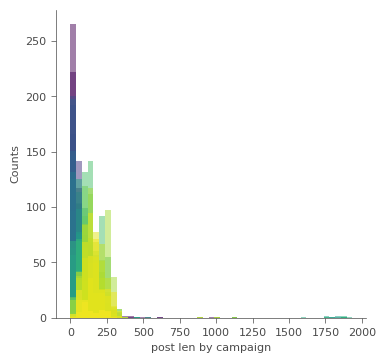

In [672]:
plot_histogram(post_len_campaigns,
               bins=50,
               xlabel='post len by campaign',
               labels=list(dfs.keys()))
#plt.legend()

In [637]:
def plot_comparison_histograms(data,
                               colors=None,
                               edgecolor='none',
                               alpha=0.5,
                               colormap='viridis',
                               xlabel=None,
                               bins=None,
                               log_bins=False,
                               log_y=False,
                               labels=None,
                               figsize=None,
                               ylabel="Counts"):
    """
    Plot comparison histograms with the first dataset appearing in every subplot,
    and each subsequent dataset compared against it in separate vertical subplots.
    
    Parameters:
    data: List of arrays/lists (must have at least 2 datasets)
    colors (list): Specific colors (if None, uses colormap spacing)
    edgecolor (str): Edge color for bars (default: 'none')
    alpha (float): Transparency level (default: 0.5)
    colormap (str): Colormap name (default: 'viridis')
    xlabel (str): X-axis label (default: None, no label)
    bins: Number of bins (default: None uses matplotlib default)
    log_bins (bool): Use log-spaced bins and log x-axis (default: False)
    log_y (bool): Use log scale for y-axis (default: False)
    labels (list): Labels for each dataset (default: None)
    figsize (tuple): Figure size (width, height). If None, auto-calculated
    """

    # Validate input
    if not isinstance(data, list) or len(data) < 2:
        raise ValueError("data must be a list with at least 2 datasets")

    # Auto-detect if data contains arrays or single values
    data_list = []
    for dataset in data:
        try:
            if isinstance(dataset[0], (list, np.ndarray)):
                data_list.append(dataset)
            else:
                data_list.append(dataset)
        except:
            data_list.append(dataset)

    # Remove NaN values from all datasets
    clean_data_list = []
    for dataset in data_list:
        clean_dataset = np.array(dataset)[~np.isnan(np.array(dataset))]
        clean_data_list.append(clean_dataset)

    if any(len(dataset) == 0 for dataset in clean_data_list):
        raise ValueError("One or more datasets contain only NaN values")

    n_datasets = len(clean_data_list)
    n_subplots = n_datasets - 1  # Number of comparison subplots

    # Set up figure size
    if figsize is None:
        figsize = (8, 3 * n_subplots)  # 3 inches height per subplot

    fig, axes = plt.subplots(n_subplots, 1, figsize=figsize, sharex=True)
    plt.subplots_adjust(hspace=0)
    # Handle case where there's only one comparison (single axis)
    if n_subplots == 1:
        axes = [axes]

    # Set up colors
    if colors is None:
        cmap = cm.get_cmap(colormap)
        if n_datasets == 1:
            colors = [cmap(0.5)]
        else:
            colors = [cmap(i / (n_datasets - 1)) for i in range(n_datasets)]

    # Calculate common bins across all datasets
    all_data = np.concatenate(clean_data_list)

    if log_bins:
        # Filter out zeros and negatives for log scale
        positive_data = all_data[all_data > 0]
        if len(positive_data) == 0:
            raise ValueError("log_bins=True requires positive values in data")

        min_val = np.min(positive_data)
        max_val = np.max(positive_data)

        if bins is None:
            bins = 50

        common_bins = np.logspace(np.log10(min_val), np.log10(max_val), bins)
    else:
        # Linear bins
        if bins is None:
            bins = 50

        min_val = np.min(all_data)
        max_val = np.max(all_data)
        common_bins = np.linspace(min_val, max_val, bins)

    # Reference dataset (first one)
    reference_data = clean_data_list[0]
    reference_color = colors[0]
    reference_label = labels[0] if labels is not None else "Reference"

    # Plot each comparison
    for i in range(n_subplots):
        ax = axes[i]

        # Current comparison dataset (i+1 because we skip the reference)
        comparison_data = clean_data_list[i + 1]
        comparison_color = colors[i + 1]
        comparison_label = labels[
            i + 1] if labels is not None else f"Dataset {i + 1}"

        # Plot reference histogram (same in every subplot)
        ax.hist(reference_data,
                bins=common_bins,
                color=reference_color,
                edgecolor=edgecolor,
                alpha=alpha,
                label=reference_label)

        # Plot comparison histogram
        ax.hist(comparison_data,
                bins=common_bins,
                color=comparison_color,
                edgecolor=edgecolor,
                alpha=alpha,
                label=comparison_label)

        # Set axis scales
        if log_bins:
            ax.set_xscale('log')

        if log_y:
            ax.set_yscale('log')

        # Style the subplot
        sns.despine(ax=ax)

        # Only add ylabel to the middle subplot
        if i == n_subplots // 2:
            ax.set_ylabel(ylabel)
        else:
            ax.set_ylabel("")

        # Don't add legend here - can be added outside function if needed

        # Style axes
        ax.tick_params(colors='#4a4a4a', width=0.5, length=2)
        ax.spines['left'].set_color('#4a4a4a')
        ax.spines['left'].set_linewidth(0.5)
        ax.spines['bottom'].set_color('#4a4a4a')
        ax.spines['bottom'].set_linewidth(0.5)
        ax.xaxis.label.set_color('#4a4a4a')
        ax.yaxis.label.set_color('#4a4a4a')
        ax.set_facecolor("none")
        ax.minorticks_off()
    # Only add xlabel to the bottom subplot
    if xlabel is not None:
        axes[-1].set_xlabel(xlabel)

    # Adjust layout to prevent overlap
    #plt.tight_layout()

    # Set same y-limits for all subplots
    # Find the maximum y-limit across all subplots
    max_ylim = 0
    for ax in axes:
        current_ylim = ax.get_ylim()[1]
        max_ylim = max(max_ylim, current_ylim)
    # Apply the same y-limit to all subplots
    for ax in axes:
        ax.set_ylim(0, max_ylim)
        ax.set_yticks([0, np.round(max_ylim*.7/10)*10])
    return fig, axes

(<Figure size 200x400 with 6 Axes>,
 array([<Axes: >, <Axes: >, <Axes: >, <Axes: ylabel='Counts'>, <Axes: >,
        <Axes: xlabel='Creativity 2 \nsequential semantic shift'>],
       dtype=object))

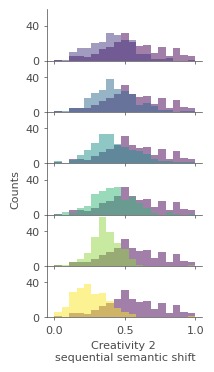

In [533]:
plot_comparison_histograms(
    sbert_post_distances,  #post_len_campaigns,
    bins=20,
    xlabel='Creativity 2 \nsequential semantic shift',
    figsize=(2, 4))
#plt.tight_layout()
#plt.savefig('single_creativity1.pdf', transparent=True)

In [521]:
#plot_comparison_histograms(
#    dsi_scenes,  #post_len_campaigns,#
#    bins=20,
#    xlabel='Creativity 3 \ndivergent semantic integration',
#    figsize=(2, 4))

#plt.subplots_adjust(hspace=0)

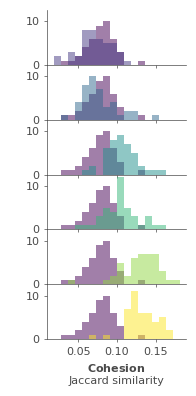

In [534]:
plot_comparison_histograms(cohesion_session_scores,#post_len_campaigns,
                           bins=19,
                           xlabel=r'$\mathbf{Cohesion}$' +  '\nJaccard similarity',
                           ylabel=" ",
                           figsize=(2,4))
plt.tight_layout()
plt.subplots_adjust(hspace=0)
plt.savefig('human_vs_llm_cohesion.pdf', transparent=True)

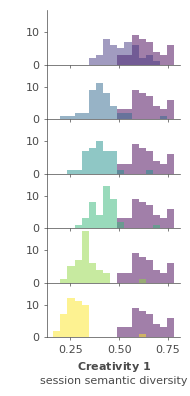

In [531]:
plot_comparison_histograms(
    sbert_session_creativity,  #post_len_campaigns,
    bins=18,
    ylabel=" ",
    xlabel=r'$\mathbf{Creativity\ 1}$' +  '\nsession semantic diversity',
    figsize=(2, 4))

plt.tight_layout()
plt.subplots_adjust(hspace=0)
plt.savefig('human_vs_llm_creativity.pdf', transparent=True)

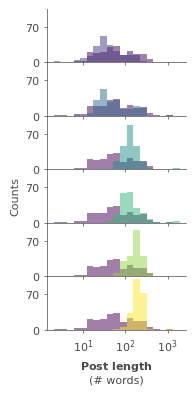

In [526]:
plot_comparison_histograms(
    post_len_campaigns,  #post_len_campaigns,
    bins=20,
    log_bins=True,
    log_y=False,
    xlabel=r'$\mathbf{Post\ length}$' + '\n(# words)',
    figsize=(2, 4))

plt.tight_layout()
plt.subplots_adjust(hspace=0)
plt.savefig('human_vs_llm_len.pdf', transparent=True)

In [638]:
mean_sbert_session_creat = np.zeros(len(sbert_session_creativity))
mean_cohesion_session = np.zeros(len(cohesion_session_scores))
mean_sbert_post_distances = np.zeros(len(sbert_post_distances))

for i in range(len(sbert_session_creativity)):
    mean_sbert_session_creat[i] = np.mean(sbert_session_creativity[i])
    mean_cohesion_session[i] = np.mean(cohesion_session_scores[i])
    mean_sbert_post_distances[i] = np.nanmean(sbert_post_distances[i])

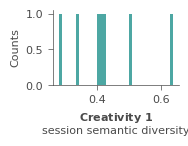

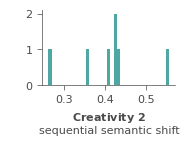

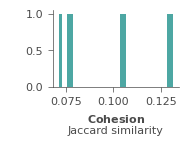

In [463]:
plt.rcParams.update({'font.size': 8})
plot_histogram(mean_sbert_session_creat,
               figsize=(2, 1.5),
               bins=40,
               alpha=0.8,
               xlabel=r'$\mathbf{Creativity\ 1}$' +  '\nsession semantic diversity',
               labels=list(dfs.keys()))
plt.tight_layout()
plt.savefig('creativity1.pdf', transparent=True)

plot_histogram(mean_sbert_post_distances,
               ylabel="   ",
               figsize=(2, 1.5),
               bins=40,
               alpha=0.8,
               xlabel=r'$\mathbf{Creativity\ 2}$' + '\nsequential semantic shift',
               labels=list(dfs.keys()))
plt.tight_layout()
plt.savefig('creativity2.pdf', transparent=True)

plot_histogram(mean_cohesion_session,
               ylabel="   ",
               figsize=(2, 1.5),
               bins=40,
               alpha=0.8,
               xlabel=r'$\mathbf{Cohesion}$' + '\nJaccard similarity',
               labels=list(dfs.keys()))
plt.tight_layout()
#plt.savefig('cohesion.pdf', transparent=True)

In [127]:
time_invervals_agg = np.concatenate(time_invervals_campaigns)
post_lengths_agg = np.concatenate(post_len_campaigns)

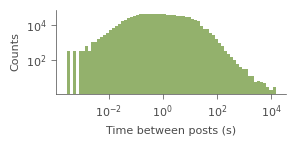

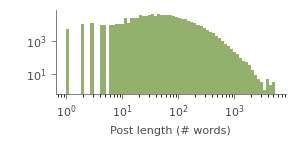

In [ ]:
plot_histogram(time_invervals_agg,
               figsize=(3, 1.5),
               log_y=True,
               bins=70,
               colors=[[.4, 0.57, .18]],
               alpha=0.7,
               log_bins=True,
               xlabel='Time between posts (h)',
               labels=list(dfs.keys()))
plt.tight_layout()
plt.savefig('time_intervals.pdf', transparent=True)

plot_histogram(post_lengths_agg,
               colors=[[.4, 0.57, .18]],
               figsize=(3, 1.5),
               alpha=0.7,
               ylabel="   ",
               log_y=True,
               bins=70,
               log_bins=True,
               xlabel='Post length (# words)',
               labels=list(dfs.keys()))
plt.tight_layout()
#plt.savefig('post_lens.pdf', transparent=True)

In [185]:
# save 5 plots
# make the simple metrics in 1 color and more complex in another? teal and chartreuse? 
# fix the x axis labels
# chartreuse (197,170,46)

In [505]:
def plot_time_series(time_var):
    plt.figure(figsize=(12, 3))
    plt.plot(time_var[0])
    plt.plot(time_var[1])
    plt.plot(time_var[2])
    plt.plot(time_var[3])
    plt.plot(time_var[4])
    #plt.plot(time_var[5])
    #plt.plot(time_var[6])

#plot_time_series(sbert_post_distances)
#plot_time_series(sbert_session_creativity)
#plot_time_series(dsi_scenes)
#plot_time_series(cohesion_session_scores)

In [338]:
len(cohesion_session_scores)
len(post_len_campaigns)


def plot_correlations(post_len_campaigns, scores, sessions=True):
    for i in range(len(post_len_campaigns)):
        #plt.figure()
        if sessions:
            session_lens = np.add.reduceat(
                post_len_campaigns[i],
                np.arange(0, len(post_len_campaigns[i]), 5))
        else: 
            session_lens = post_len_campaigns[i]
        print('\n')
        if len(session_lens) > len(scores[i]):
            plt.plot(session_lens[1:], scores[i], '.')
        else:
            plt.plot(session_lens, scores[i], '.')
        plt.xlabel('session length')
        plt.ylabel('score')

In [504]:
#plot_correlations(post_len_campaigns, cohesion_session_scores, sessions=True)

#plt.figure()
#plot_correlations(post_len_campaigns, sbert_session_creativity, sessions=True)

#plt.figure()
#plot_correlations(post_len_campaigns, sbert_post_distances, sessions=False)

#plt.figure()
#plot_correlations(dsi_scene_len, dsi_scenes, sessions=False)

In [685]:
# concetanate the chosen games scores
# then do the comparison plot

#np.concatenate(cohesion_session_scores[0:5])


def aggregate_by_category(metric_campaigns):
    metric_campaigns_human = np.concatenate(metric_campaigns[0:7])
    metric_campaigns_gemini_no_players = np.array([])
    metric_campaigns_gemini_players = np.array([])
    metric_campaigns_chatgpt_no_players = np.array([])
    metric_campaigns_chatgpt_players = np.array([])
    metric_campaigns_claude_players = np.array([])
    metric_campaigns_claude_no_players = np.array([])
    print(len(post_len_campaigns))
    print(len(CAMPAIGN_NAME))
    for i in range(len(CAMPAIGN_NAME)):
        if 'gemini-1.5-pro_no_players' in CAMPAIGN_NAME[i]:
            metric_campaigns_gemini_no_players = np.append(metric_campaigns_gemini_no_players, metric_campaigns[i])
        if 'gemini-1.5-pro_players' in CAMPAIGN_NAME[i]:
            metric_campaigns_gemini_players = np.append(metric_campaigns_gemini_players, metric_campaigns[i])
        if 'gpt-4o_no_players' in CAMPAIGN_NAME[i]:
            metric_campaigns_chatgpt_no_players = np.append(metric_campaigns_chatgpt_no_players, metric_campaigns[i])
        if 'gpt-4o_players' in CAMPAIGN_NAME[i]:
            metric_campaigns_chatgpt_players =  np.append(metric_campaigns_chatgpt_players, metric_campaigns[i])
        if 'claude-3-7-sonnet-latest_no_players' in CAMPAIGN_NAME[i]:
            metric_campaigns_claude_no_players =  np.append(metric_campaigns_claude_no_players, metric_campaigns[i])
        if 'claude-3-7-sonnet-latest_players' in CAMPAIGN_NAME[i]:
            metric_campaigns_claude_players =  np.append(metric_campaigns_claude_players, metric_campaigns[i])

    metric_agg = [
        metric_campaigns_human, metric_campaigns_gemini_no_players,
        metric_campaigns_gemini_players, metric_campaigns_claude_no_players,
        metric_campaigns_claude_players, metric_campaigns_chatgpt_no_players,
        metric_campaigns_chatgpt_players
    ]
    return metric_agg

49
49
49
49
49
49
49
49


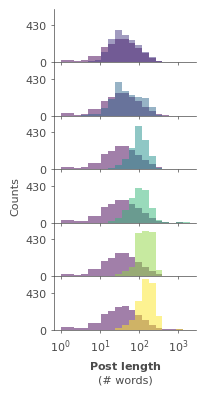

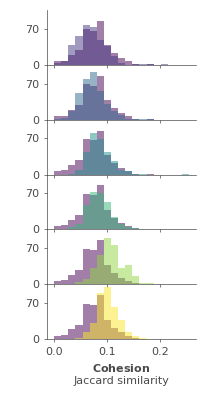

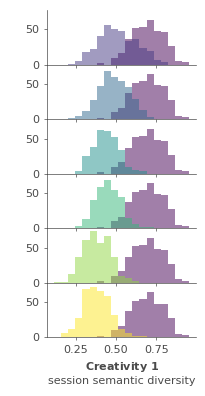

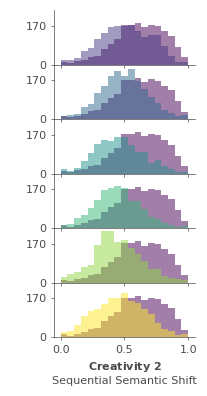

In [688]:
post_len_agg = aggregate_by_category(post_len_campaigns)
cohesion_agg = aggregate_by_category(cohesion_session_scores)
creativity_1_agg = aggregate_by_category(sbert_session_creativity)  #
creativity_2_agg = aggregate_by_category(sbert_post_distances)
plt.rcParams.update({'font.size': 8})
plot_comparison_histograms(
    post_len_agg,  #post_len_campaigns,
    bins=20,
    log_bins=True,
    log_y=False,
    xlabel=r'$\mathbf{Post\ length}$' + '\n(# words)',
    figsize=(2.1, 4))

plt.tight_layout()
plt.subplots_adjust(hspace=0)
plt.savefig('human_vs_llm_len.pdf', transparent=True)


plot_comparison_histograms(cohesion_agg,
                           bins=20,
                           log_bins=False,
                           ylabel=" ",
                           xlabel=r'$\mathbf{Cohesion}$' +
                           '\nJaccard similarity',
                           figsize=(2.1, 4))
plt.tight_layout()
plt.subplots_adjust(hspace=0)
plt.savefig('human_vs_llm_cohesion.pdf', transparent=True)


plot_comparison_histograms(
    creativity_1_agg,
    bins=20,
    log_bins=False,
    ylabel=" ",
    xlabel=r'$\mathbf{Creativity\ 1}$' +  '\nsession semantic diversity',
    figsize=(2.1, 4))
plt.tight_layout()
plt.subplots_adjust(hspace=0)
plt.savefig('human_vs_llm_creativity.pdf', transparent=True)

plot_comparison_histograms(
    creativity_2_agg,
    bins=20,
    log_bins=False,
    ylabel=" ",
    xlabel=r'$\mathbf{Creativity\ 2}$' +  '\nSequential Semantic Shift',
    figsize=(2.1, 4))
plt.tight_layout()
plt.subplots_adjust(hspace=0)
#plt.savefig('human_vs_llm_creativity.pdf', transparent=True)